Groundwater | Case Study

# Topic 4 : From Concept to Code: Implementing the Limmat Valley Model

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

In [1]:
# Import libraries
# Import libraries
import sys
import os
import time
import pandas as pd
import geopandas as gpd
import pickle
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
from shapely.affinity import rotate, translate, scale
from scipy.interpolate import griddata
import rasterio
from rasterio.warp import reproject, Resampling, transform_bounds


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import flopy
import flopy.plot as fpl
from flopy.discretization import StructuredGrid
from flopy.utils import Raster, GridIntersect

# Add the support repo to the path
sys.path.append('../SUPPORT_REPO/src')
sys.path.append('../SUPPORT_REPO/src/scripts/scripts_exercises')

# Import local modules
from data_utils import download_named_file, get_default_data_folder
from print_images import display_image
from progress_tracking import (
    create_model_implementation_progress_tracker, 
    create_model_implementation_step_completion_marker, 
)


Starting search for project root from: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling
Found project root: /Users/bea/Documents/GitHub/applied_groundwater_modelling (marker: config.py)
Loaded configuration from 'config.py'


In the previous steps, we defined our modeling objectives and developed a perceptual model of the Limmat Valley aquifer. We gathered data on the aquifer's geometry, its boundaries, and the key hydrological processes like recharge and river interaction.

Now, we will translate this perceptual understanding into a numerical groundwater model using **MODFLOW 2005** and the Python package **FloPy**. This means we describe the aquifer with numbers and grids, so a computer can simulate water movement. This process involves several key steps:

1.  **Discretization:** Defining the model grid (layers, rows, columns) that will represent our aquifer in space.
2.  **Parameterization:** Assigning hydraulic properties (like conductivity and storage) to the grid cells.
3.  **Boundary Conditions:** Implementing the physical boundaries of our system, such as rivers, recharge, and wells.
4.  **Solving:** Choosing a numerical solver and running the simulation.
5.  **Post-processing:** Visualizing and analyzing the initial results.

You can use the checklist below to keep track of your progress:

In [ ]:
create_model_implementation_progress_tracker()

## Workspace Setup
Let's begin by setting up our model workspace. This involves creating a flopy workspace that we will fill with the model grid, boundary conditions, and other necessary components as we progress through the case study.

In [2]:
# --- 1. Model Setup and Workspace ---
# Define the name of our model and the workspace where files will be stored.
# We'll create a directory in your default data folder for this course to keep 
# things organized. 
model_name = 'limmat_valley_model'
workspace = os.path.join(get_default_data_folder(), model_name)

# Create the workspace directory if it doesn't exist
os.makedirs(workspace, exist_ok=True)

# Define the path to the MODFLOW executable
# We assume it's in a standard location accessible from the system's PATH.
executable = 'mf2005' 

# Create the MODFLOW model object
# The model object is the main object in FloPy that represents the MODFLOW model.
# It manages all the information about the model, including the grid, boundary 
# conditions, and other settings.
# We'll fill it with the necessary components as we go along.
mf = flopy.modflow.Modflow(
    modelname=model_name, 
    model_ws=workspace, 
    exe_name=executable
)

In [ ]:
create_model_implementation_step_completion_marker(1)

## Model Grid

The first step is to define the spatial domain of our model. Based on our perceptual model, we will create a single-layer model. A single-layer model is a 2D model. This 2D model can still represent thickness and vertical flows. For this reason, people sometimes call it quasi-3D or 2.5D. 

We choose a grid size of 50 meters by 50 meters to start with. This means that each grid cell will represent a 50m x 50m area in the real world. This is a compromise between detail and computational efficiency. It will not allow us to capture small-scale features, but it will provide a good overview of the aquifer's behavior. We can refine the grid later in the modelling process if needed and we can assess the impact of the model resolution on the results in the sensitivity analysis.

We start with an initial grid and then rotate it to align with the flow direction. This will help us reduce the number of model cells and speed up the model run time.

### Initial Grid Definition
Please follow the documented steps in the code cell below to create the initial grid. This grid is based on the model boundary polygon we defined in teh previous notebook. 

limmat_model_boundary.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
limmat_model_boundary_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Model grid created with the following parameters:
xll:2676732.1290222453; yll:1246750.8207069656; rotation:0; crs:EPSG:2056; units:meters; lenuni:2


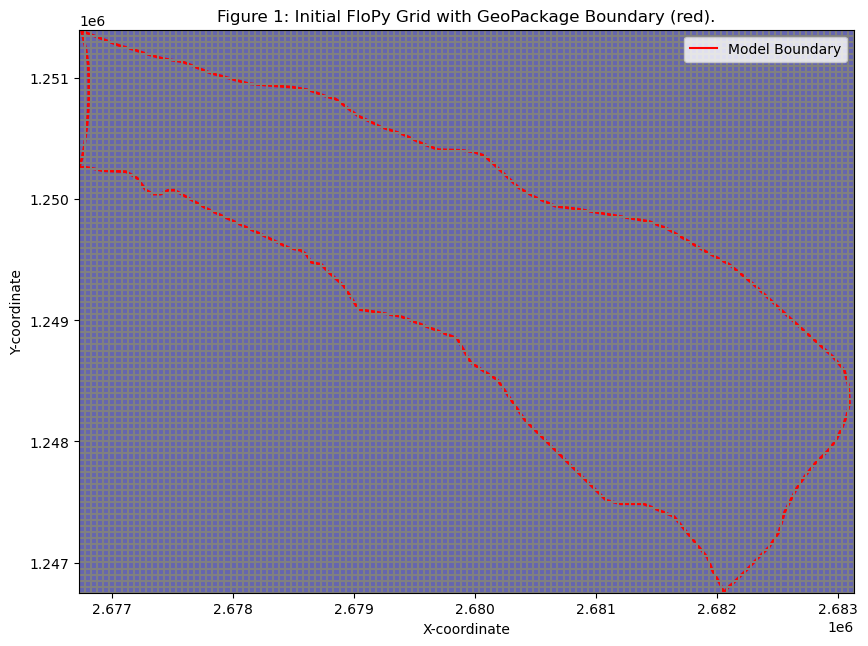

Total number of cells in the grid: 11904


In [3]:
# --- 2.a Initial Discretization (DIS Package) --- 
# Get the model boundary polygon
boundary_path = download_named_file(
    name='model_boundary',
    data_type='gis'
)
gdf = gpd.read_file(boundary_path)

# Get the bounding box of the geometry in your GeoPackage
# Assuming you want to use the total bounds of all geometries in the GeoPackage
xmin, ymin, xmax, ymax = gdf.total_bounds

# Rotation of the grid to minimize the number of cells. The grid is rotated 
# around the lower left corner (xll, yll).
rotation = 0  # degrees, let's first see how it looks without rotation.

# Define grid dimensions
cell_size = 50  # meters

# Calculate number of rows and columns
ncol = int(np.ceil((xmax - xmin) / cell_size))
nrow = int(np.ceil((ymax - ymin) / cell_size))

# Define delr and delc (cell widths along rows and columns)
# Delr and delc are the widths of the grid cells in the x and y directions, respectively.
# Here, we assume a uniform grid, so we can use the same cell size for all cells.
# If you have varying cell sizes, you would need to define them accordingly.
# For a non-uniform grid, you would typically provide arrays of varying sizes.
# Here, we use np.full to create arrays filled with the cell_size value.
# For a regular grid, these will be arrays of the cell_size
delr = np.full(ncol, cell_size)
delc = np.full(nrow, cell_size)

# Define the origin of the grid (lower-left corner)
# FloPy by default assumes the origin (xll, yll) is the lower-left corner
xll = xmin
yll = ymin

# You'll also need to define the top and bottom of your model layers.
# For a basic grid creation, you can use dummy values.
# Let's assume a single vertical layer for now.
nlay = 1

# We use dummy data for the top and the bottom elevation for now. We'll replace 
# these with actual data later.
top = np.ones((nrow, ncol)) * 100 # Dummy top elevation
botm = np.ones((nlay, nrow, ncol)) * 50 # Dummy bottom elevation

# Create the structured grid object
# The StructuredGrid object is used to define the grid structure in FloPy.
# Check out the documentation for more details: 
# https://flopy.readthedocs.io/en/stable/source/flopy.discretization.structuredgrid.html
modelgrid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=xll,
    yoff=yll,
    angrot=rotation,
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)
print("Model grid created with the following parameters:")
print(modelgrid)

# Plotting the grid 
fig, ax = plt.subplots(1, 1, figsize=(10, 10)) # Adjusted figsize to be more square if needed
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax) # Pass ax directly
pc = pmv.plot_array(modelgrid.top, alpha=0.5, cmap='terrain') # Added cmap for better visualization
pmv.plot_grid()

# Plot the GeoPackage boundary on top for verification
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
# Add a legend for the boundary
boundary_legend = mlines.Line2D([], [], color='red', label='Model Boundary')
ax.legend(handles=[boundary_legend], loc='upper right')

ax.set_title("Figure 1: Initial FloPy Grid with GeoPackage Boundary (red).")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

# Count the number of cells in the grid
total_cells = ncol * nrow * nlay
print(f"Total number of cells in the grid: {total_cells}")


Congratulation! You have successfully set up your first model grid and display it in Figure 1. The grid is a fundamental part of the model, as it defines the spatial resolution and extent of the simulation.  
  

You will notice, that most of the cells are outside the model boundary. This is inefficient as the entire matrix will be solved, even if some cells are not part of the model. 

### Grid Rotation and Buffering
To reduce the number of cells in the model, we will rotate the model grid to align it with the model boundary. We will also buffer the model boundary to ensure that the grid cells cover the entire area of interest. The easiest way to do that are by following the steps below: 
1. Rotate the model boundary polygon to minimize the number of grid cells. 
2. Buffer the rotated model boundary polygon to ensure that the grid cells cover the entire area of interest and are not cut off.
3. Create a new grid based on the buffered polygon and apply the rotation.

We start with the rotation of the model boundary polygon. It should be rotated to minimize the number of grid cells outside the model boundary. Optimally, the grid cells should be aligned with the main flow direction.  

The rotation angle (variable `grid_rotation_angle` in code below) can be adjusted by trial and error to find the best fit.

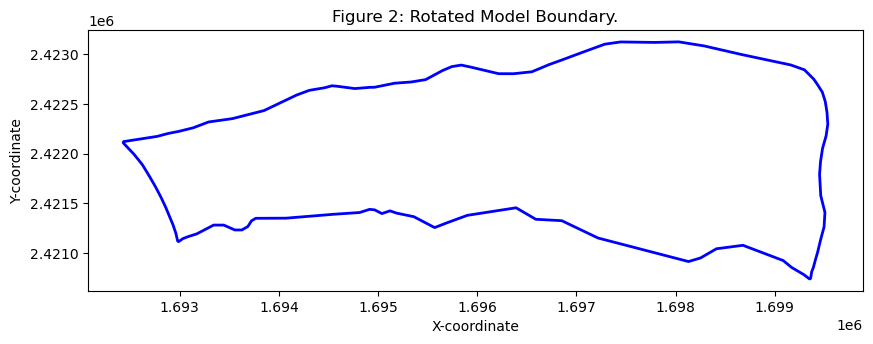

Original Boundary Bounds: xmin=2676732, ymin=1246751, xmax=2683093, ymax=1251390
Rotated Boundary Bounds: xmin=1692430, ymin=2420736, xmax=1699536, ymax=2423127
Width of Rotated Boundary: 7106 meters
Height of Rotated Boundary: 2390 meters
Width of Original Boundary: 6361 meters
Height of Original Boundary: 4639 meters


In [8]:
# To generate a rotated grid in FloPy, the easiest way is to create a regular 
# grid and then apply a rotation transformation to it. 
# We first rotate the model boundary polygon to the desired angle. From there, 
# we can create a regular grid and then apply the rotation to the grid.
# This approach allows us to maintain the integrity of the grid while applying
# the desired rotation.

# --- 2.b Rotation of the Model Boundary ---
# Buffer the model boundary gdf
gdf['geometry'] = gdf['geometry'].buffer(10)

# Define the rotation angle in degrees
grid_rotation_angle = 30  # degrees, by trial and error, you can adjust this angle to minimize the number of cells outside the boundary
origin_rotation = Point(0, 0)  # Origin for rotation, can be adjusted as needed
# Rotate the model boundary polygon
gdf_rotated = gdf.copy()

gdf_rotated['geometry'] = gdf_rotated['geometry'].apply(
    lambda geom: rotate(geom, grid_rotation_angle, origin=origin_rotation)
)
# Get the bounding box of the rotated geometry
xmin_rotated, ymin_rotated, xmax_rotated, ymax_rotated = gdf_rotated.total_bounds
# Plot the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_rotated.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
ax.set_title("Figure 2: Rotated Model Boundary.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

# Print xmin, ymin, xmax, ymax of the original boundary
print(f"Original Boundary Bounds: xmin={xmin:.0f}, ymin={ymin:.0f}, xmax={xmax:.0f}, ymax={ymax:.0f}")
# Print xmin, ymin, xmax, ymax of the rotated boundary
print(f"Rotated Boundary Bounds: xmin={xmin_rotated:.0f}, ymin={ymin_rotated:.0f}, xmax={xmax_rotated:.0f}, ymax={ymax_rotated:.0f}")   
# Print the width and height of the rotated boundary
width_rotated = xmax_rotated - xmin_rotated
height_rotated = ymax_rotated - ymin_rotated
print(f"Width of Rotated Boundary: {width_rotated:.0f} meters")
print(f"Height of Rotated Boundary: {height_rotated:.0f} meters")
# Print the width and height of the original boundary
width_original = xmax - xmin
height_original = ymax - ymin
print(f"Width of Original Boundary: {width_original:.0f} meters")
print(f"Height of Original Boundary: {height_original:.0f} meters") 

Figure 2 shows the rotated model boundary. An angle of 30 degrees seems to be suitable for the Limmat Valley model. In the next step, we will create a new grid based on this rotated model boundary (see Figure 3).

Original Grid: 128 columns, 93 rows
Rotated Grid: 142 columns, 48 rows


Text(0.5, 1.0, 'Figure 3: Rotated FloPy Grid with Rotated Boundary.')

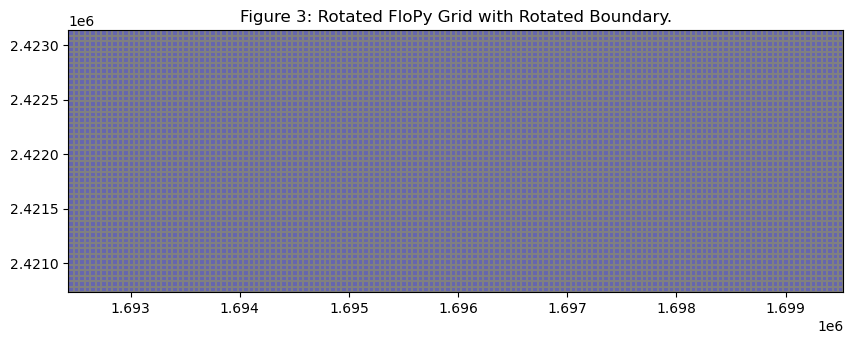

In [9]:
# --- 2.c Creation of a new Model Grid based on the rotated Model Boundary ---
# We now have new bounding box coordinates for the rotated model boundary. 
# These we need to rotate back to the original coordinate system to create a
# regular grid that fits the rotated boundary.
# We use the rotated bounding box to define the grid dimensions.
# Calculate the new grid dimensions based on the rotated bounding box
# Calculate the width and height of the rotated bounding box
width_rotated = xmax_rotated - xmin_rotated
height_rotated = ymax_rotated - ymin_rotated

# Calculate the number of rows and columns based on the rotated bounding box
ncol_rotated = int(np.ceil(width_rotated / cell_size)) - 1 # Based on visual inspection of rotated grid.
nrow_rotated = int(np.ceil(height_rotated / cell_size))

# Compare number of rows and columns with the original grid
print(f"Original Grid: {ncol} columns, {nrow} rows")
print(f"Rotated Grid: {ncol_rotated} columns, {nrow_rotated} rows")

# Define the delr and delc for the rotated grid
delr_rotated = np.full(ncol_rotated, cell_size)
delc_rotated = np.full(nrow_rotated, cell_size) 

# Plot the rotated grid and the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create a new StructuredGrid with the rotated dimensions
rotated_grid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=np.ones((nrow_rotated, ncol_rotated)) * 100,  # Example top elevation
    botm=np.ones((nlay, nrow_rotated, ncol_rotated)) * 50,  # Example bottom elevation
    xoff=xmin_rotated,  # Use the lower-left of the rotated extent
    yoff=ymin_rotated,  # Use the lower-left of the rotated extent
    angrot=0,  # We are currently in the rotated coordinate system, so no additional rotation is needed
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf_rotated.crs.to_string()  # Automatically get CRS from geopackage
)
pmv = flopy.plot.PlotMapView(modelgrid=rotated_grid, ax=ax)
pc = pmv.plot_array(rotated_grid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
ax.set_title("Figure 3: Rotated FloPy Grid with Rotated Boundary.")

Original coordinates after inverse rotation:
xmin: 2676055.63, ymin: 1250203.89
xmax: 2683404.68, ymax: 1248721.21
Corrected grid lower-left corner:
xll = 2676055.63
yll = 1250203.89
Number of cells in the rotated grid: 6816
Number of cells in the original grid: 11904
The rotated grid has 43 % less cells than the initial grid.
Model grid created with the following parameters:
xll:2676055.6265532523; yll:1250203.8923757293; rotation:-30; crs:EPSG:2056; units:meters; lenuni:2


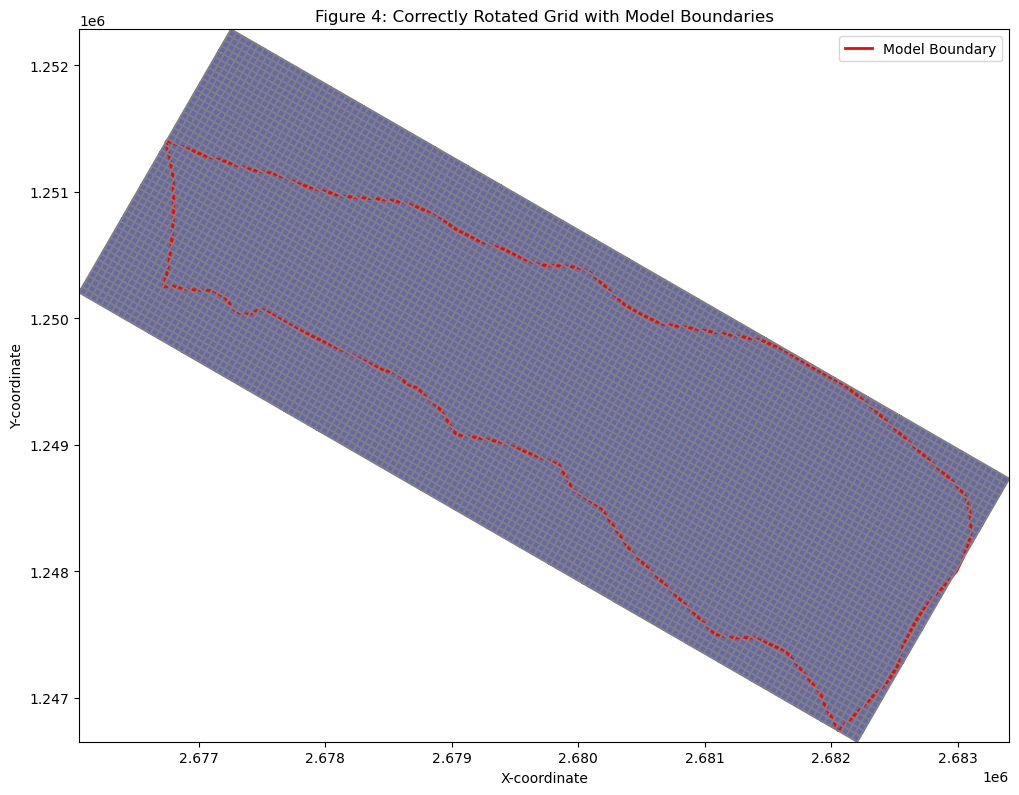

In [10]:
# --- 2.d Rotation of the new Model Grid in the CH Coordinate System ---
# Now we need to rotate the lower-left corner of the rotated grid back to the 
# original coordinate system.
# The lower-left corner of the rotated bounding box
# Create points from the rotated bounding box coordinates
min_point_rotated = Point(xmin_rotated, ymin_rotated)
max_point_rotated = Point(xmax_rotated, ymax_rotated)

# Apply inverse rotation (negative angle) around the same origin
min_point_original = rotate(min_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)
max_point_original = rotate(max_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)

# Extract the coordinates
xmin_original = min_point_original.x
ymin_original = min_point_original.y
xmax_original = max_point_original.x
ymax_original = max_point_original.y

print(f"Original coordinates after inverse rotation:")
print(f"xmin: {xmin_original:.2f}, ymin: {ymin_original:.2f}")
print(f"xmax: {xmax_original:.2f}, ymax: {ymax_original:.2f}")

xll = xmin_original
yll = ymin_original

print(f"Corrected grid lower-left corner:")
print(f"xll = {xll:.2f}")
print(f"yll = {yll:.2f}")
print(f"Number of cells in the rotated grid: {nrow_rotated * ncol_rotated * nlay}")
print(f"Number of cells in the original grid: {nrow * ncol * nlay}")
print(f"The rotated grid has {round(((nrow * ncol * nlay) - (nrow_rotated * ncol_rotated * nlay))/(nrow * ncol * nlay)*100)} % less cells than the initial grid.")

# Update the top and bottom elevation arrays
# For simplicity, we keep the dummy elevations. They are reset later.
top = np.ones((nrow_rotated, ncol_rotated)) * 100  # Example top elevation
botm = np.ones((nlay, nrow_rotated, ncol_rotated)) * 50  # Example bottom elevation

# Create the FloPy structured grid with the rotated bounding box
modelgrid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=top,
    botm=botm,
    xoff=xmin_original,  # Use the lower-left of the rotated extent
    yoff=ymin_original,  # Use the lower-left of the rotated extent
    angrot=-grid_rotation_angle,  # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string()  # Automatically get CRS from geopackage
)
print("Model grid created with the following parameters:")
print(modelgrid)
# Add the modelgrid to the MODFLOW model
mf.modelgrid = modelgrid

# Plot the rotated grid and the model_boundary to check alignment
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
pc = pmv.plot_array(mf.modelgrid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid() 

gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.legend(handles=[red_line], loc='upper right')
ax.set_title("Figure 4: Correctly Rotated Grid with Model Boundaries")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio

Figure 4 shows the correctly rotated grid with model boundaries. By rotating the grid, we can significantly reduce the number of model cells, which will significantly speed up the model run time.

Let's export the model grid to a shapefile in case we want to use it for visualizations outside flopy. Visualizing it in a different context, e.g. in QGIS, is a good sanity check. This will help us to verify that the grid is correctly aligned with the model boundary and that the cells are not too large or too small (see Figure 5).

In [13]:
# Export the model grid to shapefile
# Create a list to store grid cell polygons
grid_cells = []

# Get grid cell vertices using FloPy's grid functionality
for i in range(modelgrid.nrow):
    for j in range(modelgrid.ncol):
        # Get cell vertices
        cell_vertices = modelgrid.get_cell_vertices(i, j)
        
        # Create polygon from vertices
        cell_polygon = Polygon(cell_vertices)
        
        # Store cell information
        grid_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': cell_polygon,
            'x': modelgrid.xcellcenters[i, j],
            'y': modelgrid.ycellcenters[i, j]
        })

# Create GeoDataFrame
grid_gdf = gpd.GeoDataFrame(grid_cells, crs=modelgrid.crs)

# Export to GeoPackage
grid_geopackage_path = os.path.join(workspace, 'model_grid.gpkg')
grid_gdf.to_file(grid_geopackage_path, driver='GPKG', layer='model_grid')

print(f"Model grid exported to: {grid_geopackage_path}")

Model grid exported to: /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model/model_grid.gpkg


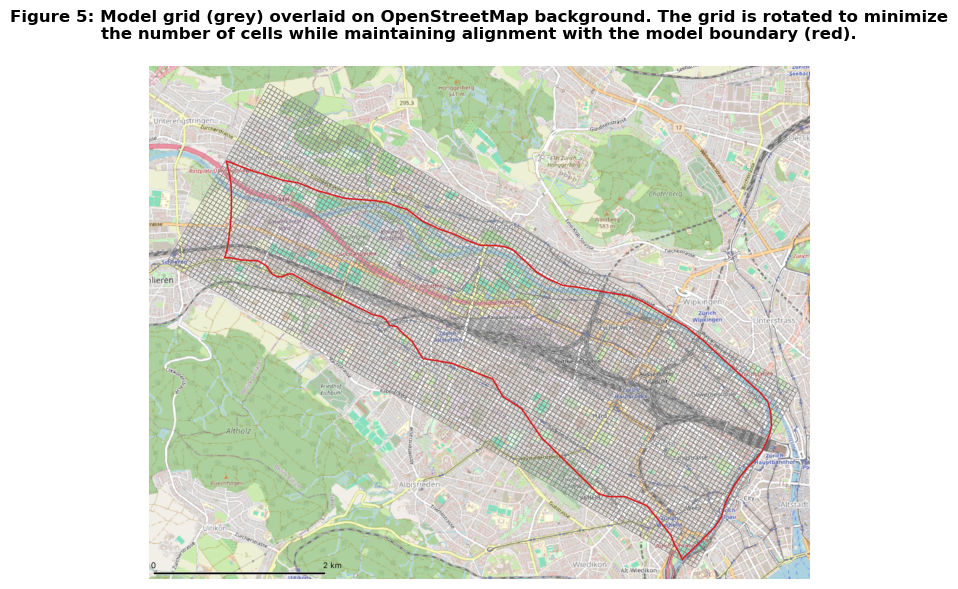

In [16]:
display_image(
    image_filename='model_grid_on_openstreetmap.png', 
    image_folder='4_model_implementation',
    caption='Figure 5: Model grid (grey) overlaid on OpenStreetMap background. The grid is rotated to minimize the number of cells while maintaining alignment with the model boundary (red). '
)

We now have a regular grid that fits the rotated boundary. The grid is defined by its origin, the number of rows and columns, and the cell size. The grid is a fundamental part of the model, as it defines the spatial resolution and extent of the simulation. 


In [ ]:
create_model_implementation_step_completion_marker(2)

> **Optional Challenge:**   
> Try to find a better rotation angle by adjusting the `grid_rotation_angle` variable in the code above. You can also try to change the `cell_size` to see how it affects the number of cells outside the model boundary.

## Model Top
Now that we have the model grid, let's define the top of the model. The top of the model will be defined by the DEM, which we will use to create a single layer model. The DEM will have to be resampled on the model grid. Let's have a look at our DEM in the model area (Figure 6). 

dem_converted_bbox.tif already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
dem_converted_bbox_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.


Text(0.5, 1.0, 'Figure 6: DEM in original resolution in the model area.')

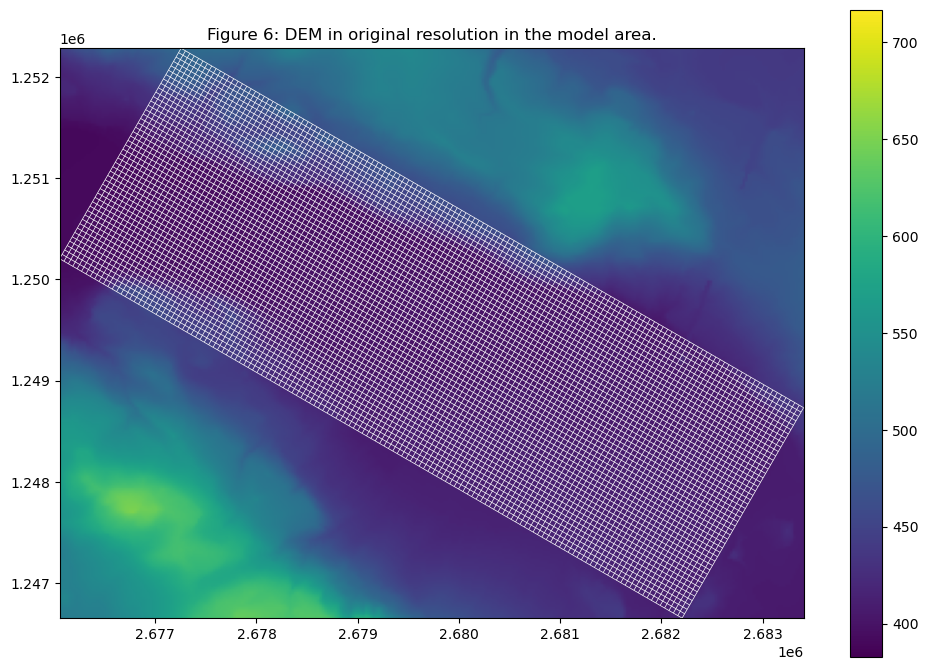

In [17]:
# --- 3. Model Top ---
# Load the DEM data
dem_path = download_named_file(
    name='dem',
    data_type='gis'
)

# Assuming the DEM is in the same CRS as the model grid, we can resample it to match the grid.
rio = Raster.load(dem_path)

arr = rio.get_array(1)
idx = np.isfinite(arr)

vmin, vmax = arr[idx].min(), arr[idx].max()
vmin, vmax

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

ax = rio.plot(ax=ax, vmin=vmin, vmax=vmax)
plt.colorbar(ax.images[0], shrink=0.7)
pmv.plot_grid(ax=ax, lw=0.5, color="white")
ax.set_title("Figure 6: DEM in original resolution in the model area.")


The resolution of the DEM does not match the model grid resolution, so we will resample the DEM to fit the model grid. We will use the `rio.resample_to_grid` function to resample the DEM to the model grid resolution. This will create a new raster that matches the model grid resolution and can be used as the model top (Figure 7).

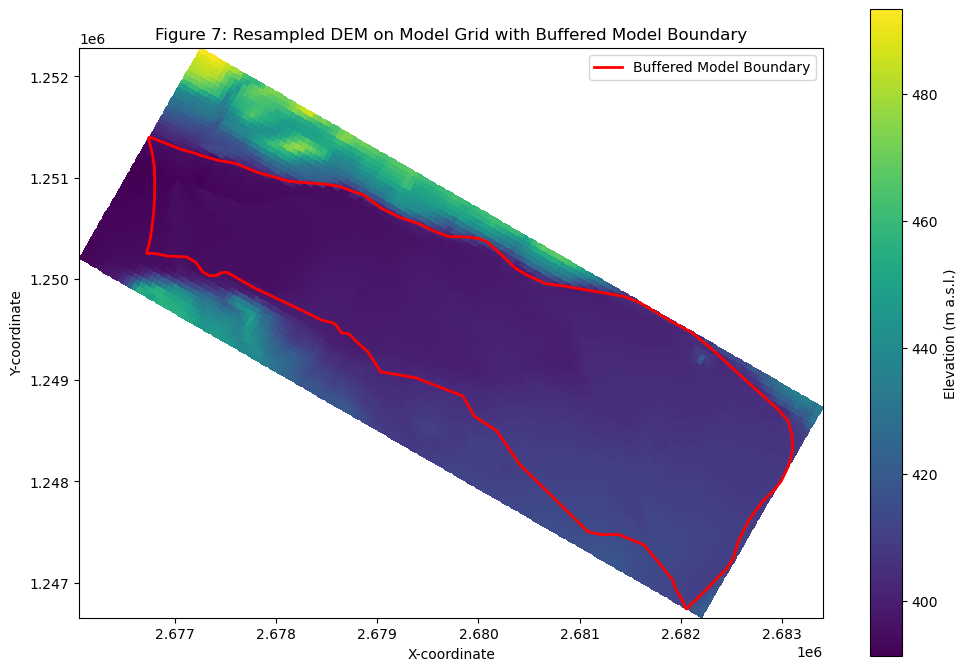

In [18]:
t0 = time.time() # To log the time it takes to resample the DEM
model_top = rio.resample_to_grid(modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# We round to 10 centimeters to avoid having to store too many digits
model_top = np.round(model_top, 1)

# Update vmin and vmax based on the resampled data
vmin, vmax = model_top.min(), model_top.max()

# Now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_top, masked_values=rio.nodatavals, vmin=vmin, vmax=vmax)

# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

plt.title(f"Resample time, nearest neighbor: {resample_time:.3f} sec")
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])
ax.set_title("Figure 7: Resampled DEM on Model Grid with Buffered Model Boundary")

# Save the model top layer to a file for later use
top_file_path = os.path.join(workspace, 'model_top.npy')
np.save(top_file_path, model_top)

In [ ]:
create_model_implementation_step_completion_marker(3)

## Model Bottom

Next we tackle the bottom layer. The groundwater map of the canton of Zurich shows contour lines of the thickness of the aquifer for the deeper zones but for the shallower zones we see the range of the aquifer thickness. For the latter, we assume that the lower range corresponds to the contour line of the aquifer thickness. For the deeper zones, we will use the contour lines to define the bottom layer of the model. We'll walk you through the steps to create the bottom layer of the model in the following code cells.

We'll start by displaying the contours of aquifer thickness in the model area (Figure 8). This will help us visualize the aquifer thickness and understand how it varies across the model area. Please note that the aquifer thickness is very thin in parts of the model area. Cells in this region may run dry during the simulation, which is a common occurrence in groundwater models of shallow unconfined aquifers. By default, cells that run dry become impermeable in modflow but we can set rewetting parameters which allow the model to iteratively re-activate dry cells. This can, however, lead to numerical instability. We'll have to keep an eye on this during the simulation and adjust the model parameters for re-wetting if necessary.

Grundwasservorkommen_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Grundwasservorkommen_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.


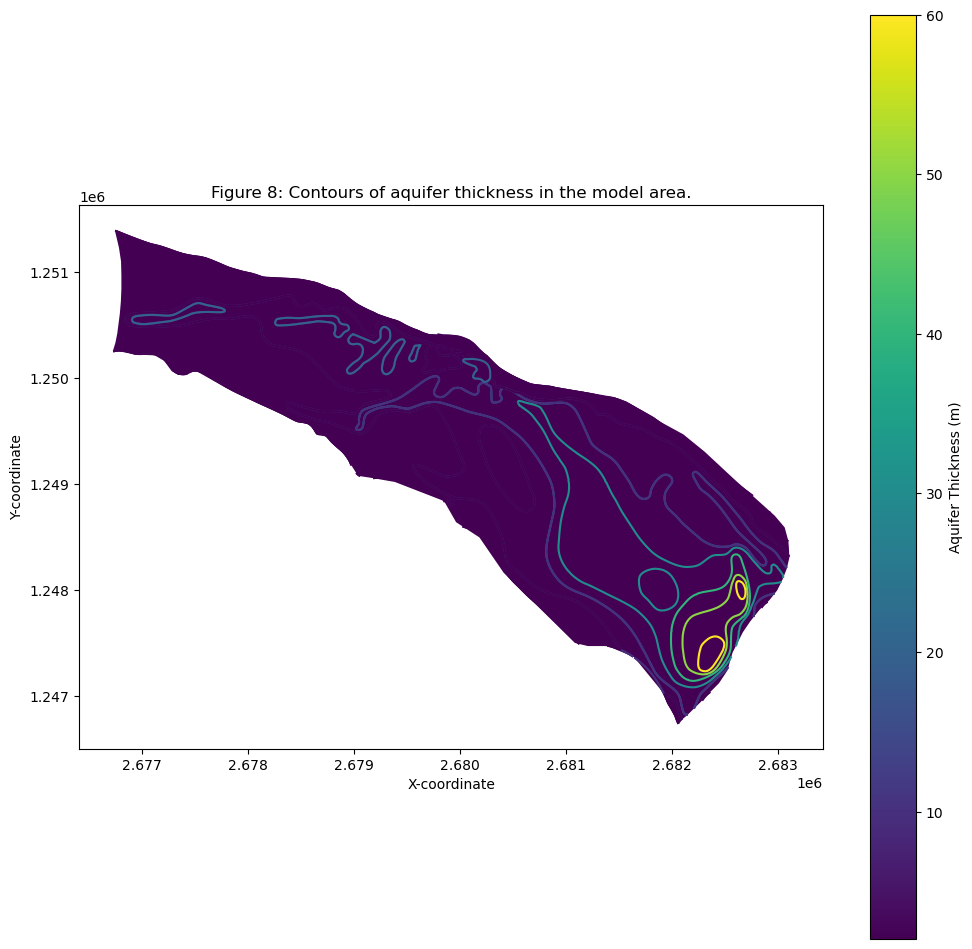

In [19]:
# --- 4 Bottom of Model ---
# a) Load the polygon layers with information about aqufier thickness.
gw_map_path = download_named_file(
    name='groundwater_map_norm', 
    data_type='gis', 
)

deep_contours_gdf = gpd.read_file(gw_map_path, layer="GS_GW_MAECHTIGKEIT_L")
shallow_gdf = gpd.read_file(gw_map_path, layer="GS_GW_LEITER_F") 

# Reproject the GeoDataFrames to match the model grid CRS
deep_contours_gdf = deep_contours_gdf.to_crs(modelgrid.crs)
shallow_gdf = shallow_gdf.to_crs(modelgrid.crs)

# For the deep contours, the aquifer thickness in meters is in the field 
# "LABEL". For the shallow contours, we have the field "GWLTYP" which corresponds 
# to a range of aquifer thickness. We have to manually assign a label attribute 
# here, using the GIS-Broswer as reference. 
# type_labels maps GWLTYP to the corresponding aquifer thickness in meters.
type_labels = {
        1: 2, 
        2: 2,
        4: 10,
        6: 20,
    }
# Create a new column 'aquifer_thickness' in shallow_gdf
shallow_gdf['aquifer_thickness'] = shallow_gdf['GWLTYP'].map(type_labels)

# Create a new column 'aquifer_thickness' in deep_contours_gdf
deep_contours_gdf['aquifer_thickness'] = deep_contours_gdf['LABEL'].astype(float)

# Discard rows in the shallow_gdf where aquifer_thickness is NaN
shallow_gdf = shallow_gdf.dropna(subset=['aquifer_thickness'])

# Now we need to make sure all shapes are available as lines. 
# Convert shallow polygons to contour lines by taking their boundaries
shallow_contours_gdf = shallow_gdf.copy()
shallow_contours_gdf.geometry = shallow_contours_gdf.geometry.boundary

# Define the buffered model boundary as a contour with 2m thickness
boundary_contour_gdf = gdf.copy()
boundary_contour_gdf['aquifer_thickness'] = 2.0

# View the first few rows of the deep contours and shallow contours
# print("Deep contours (aquifer thickness in meters):")
# print(deep_contours_gdf[['LABEL', 'aquifer_thickness']].head())
# print("\nShallow contours (aquifer thickness in meters):")
# print(shallow_gdf[['GWLTYP', 'aquifer_thickness']].head())

# Combine all contour dataframes into one
# We select only the 'aquifer_thickness' and 'geometry' columns to ensure consistency
all_contours_gdf = gpd.GeoDataFrame(
    pd.concat([
        deep_contours_gdf[['aquifer_thickness', 'geometry']],
        shallow_contours_gdf[['aquifer_thickness', 'geometry']],
        boundary_contour_gdf[['aquifer_thickness', 'geometry']]
    ], ignore_index=True),
    crs=gdf.crs
)

# Clip the contours to the model boundary polygon
clipped_gdf = gpd.clip(all_contours_gdf, gdf)

# Now we can plot the combined contours
fig, ax = plt.subplots(figsize=(12, 12))
clipped_gdf.plot(ax=ax, column='aquifer_thickness', cmap='viridis',
                 legend=True, legend_kwds={'label': "Aquifer Thickness (m)"})
ax.set_title("Figure 8: Contours of aquifer thickness in the model area.")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.show()

Now we need to subtract the aquifer thickness from the top of the model to define the bottom of the model. 

$$ \text{Bottom of the model} = \text{Top of the model} - \text{Aquifer thickness}$$

For this, we interpolate the contour lines of the aquifer thickness to the model grid (Figure 9). This will create a new raster that matches the model grid resolution which we can subtract from the top of the model to obtain the bottom elevation (Figure 10).

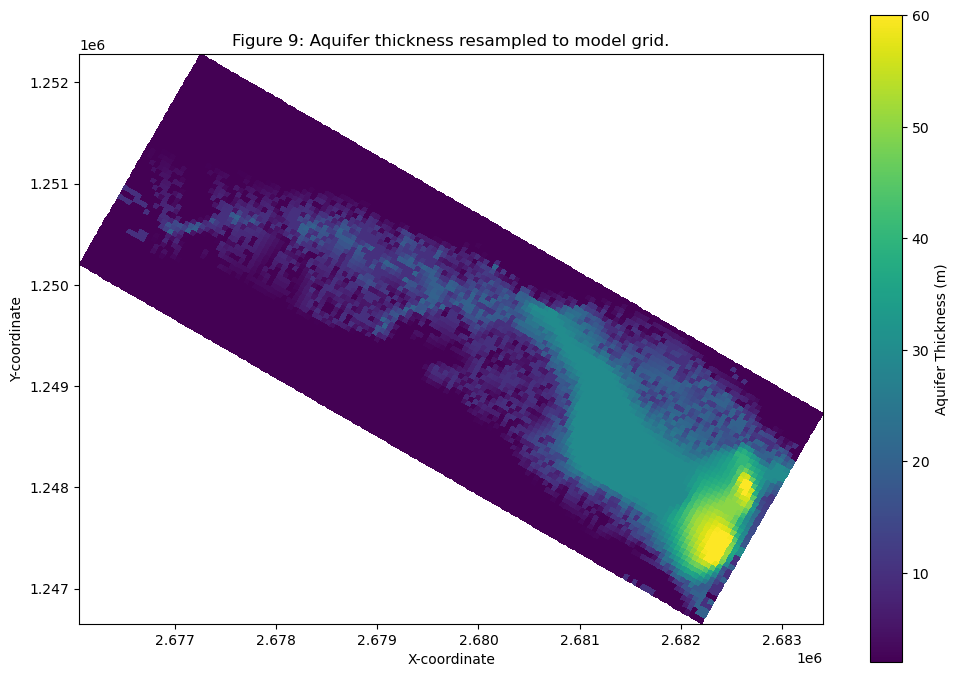

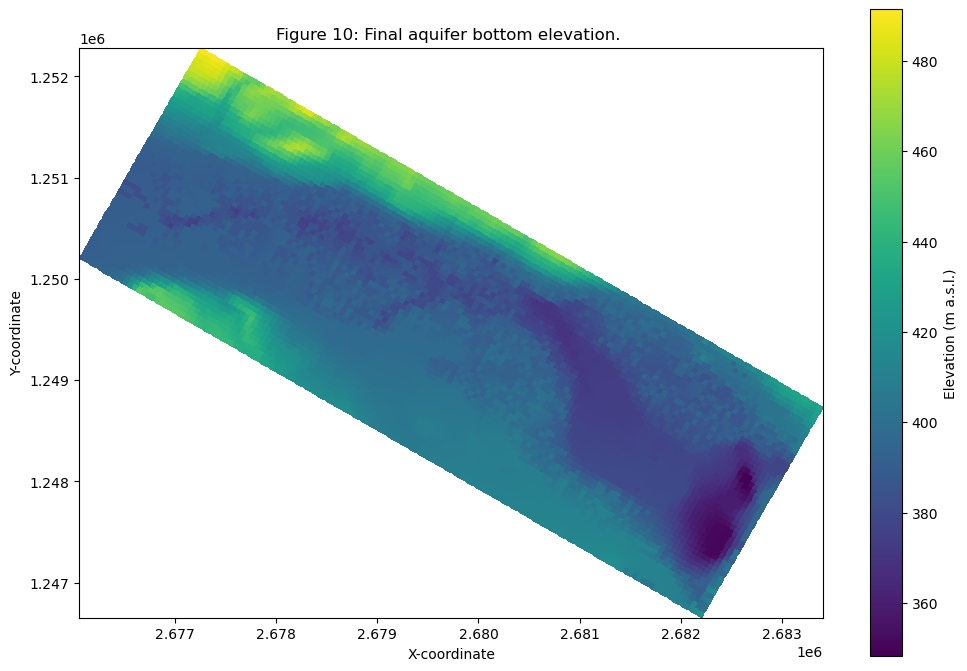

In [20]:
# b) Calculate aquifer bottom elevation
# Extract all points from the combined contour lines for interpolation
points_for_interp = []
for idx, row in clipped_gdf.iterrows():
    if row.geometry is None or row.geometry.is_empty:
        continue
    if row.geometry.geom_type == 'MultiLineString':
        for line in row.geometry.geoms:
            for x, y in line.coords:
                points_for_interp.append((x, y, row['aquifer_thickness']))
    elif row.geometry.geom_type == 'LineString':
        for x, y in row.geometry.coords:
            points_for_interp.append((x, y, row['aquifer_thickness']))

points_for_interp = np.array(points_for_interp)

# --- PLOT: Points for Interpolation of Aquifer Thickness on Model Grid ---
# Uncomment the following lines to visualize the points used for interpolation
# fig, ax = plt.subplots(figsize=(12, 12))
# sc = ax.scatter(points_for_interp[:, 0], points_for_interp[:, 1], c=points_for_interp[:, 2], cmap='viridis', s=5)
# plt.colorbar(sc, label='Aquifer Thickness (m)')
# ax.set_title("Step 1. Points from All Contours for Interpolation")
# ax.set_xlabel("X-coordinate")
# ax.set_ylabel("Y-coordinate")
# ax.set_aspect('equal', adjustable='box')
# plt.show()

# Interpolate directly onto the model grid cell centers
grid_x, grid_y = modelgrid.xcellcenters, modelgrid.ycellcenters

# First, use linear interpolation. This creates a smooth surface between contours.
aquifer_thickness_linear = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x, grid_y), 
    method='linear'
)

# Linear interpolation leaves NaNs outside the convex hull of the data.
# Second, fill these NaNs using nearest neighbor interpolation to cover the whole grid.
nan_indices = np.isnan(aquifer_thickness_linear)
aquifer_thickness_resampled = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x[nan_indices], grid_y[nan_indices]), 
    method='nearest'
)
aquifer_thickness_linear[nan_indices] = aquifer_thickness_resampled

# The final resampled grid
aquifer_thickness_resampled = aquifer_thickness_linear

# Save aquifer thickness to a file for later use
aquifer_thickness_file_path = os.path.join(workspace, 'aquifer_thickness.npy')
np.save(aquifer_thickness_file_path, aquifer_thickness_resampled)

# --- PLOT: Resampled Grid on Model Grid ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(aquifer_thickness_resampled)
plt.colorbar(im, shrink=0.7, label="Aquifer Thickness (m)")
ax.set_title("Figure 9: Aquifer thickness resampled to model grid.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
plt.show()

# Subtract the aquifer thickness from the top of the model to define the bottom
model_bottom = model_top - aquifer_thickness_resampled

# Ensure the model bottom is a 3d array (nlay, nrow_rotated, ncol_rotated)
if model_bottom.ndim == 2:
    model_bottom = model_bottom[np.newaxis, :, :]  # Add a new axis for layers

# --- PLOT: Final Aquifer Bottom ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_bottom, vmin=np.nanmin(model_bottom), vmax=np.nanmax(model_bottom))
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
ax.set_title("Figure 10: Final aquifer bottom elevation. ")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
plt.show()

Now we replace the dummy model top in the model object with our resampled DEM. This will ensure that the model top reflects the actual topography of the Limmat Valley. Let's visualize the final model grid with the top elevation (Figure 11) for verification.  

Please note that when defining the DIS package, we can also pass the temporal discretization parameters directly to the DIS package constructor (see code snippet below). We will start out with a steady state simulation, so we only need one stress period. If you have transient data, you would define multiple stress periods. Here, we define a single stress period with a length of 1 day.  

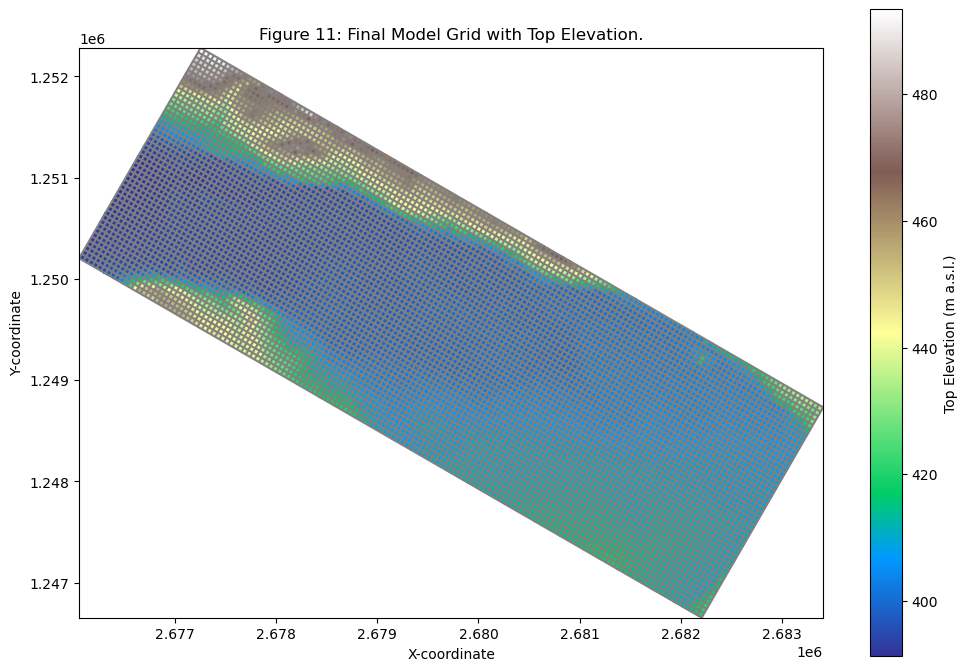

In [21]:
# Add new model top and bottom to the modelgrid
modelgrid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=model_top,
    botm=model_bottom,
    nlay=nlay,
    xoff=xmin_original, # Use the lower-left of the rotated extent
    yoff=ymin_original, # Use the lower-left of the rotated extent
    angrot=-grid_rotation_angle, # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)

# Update the modelgrid in the MODFLOW model
mf.modelgrid = modelgrid

# Plot the mf modelgrid to verify
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
im = pmv.plot_array(mf.modelgrid.top, vmin=np.nanmin(mf.modelgrid.top), vmax=np.nanmax(mf.modelgrid.top), cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Top Elevation (m a.s.l.)")
pmv.plot_grid()
ax.set_aspect('equal', adjustable='box')
ax.set_title("Figure 11: Final Model Grid with Top Elevation.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

# Temporal discretization
# We start out with a steady state simulation, so we only need one stress period.
# If you have transient data, you would define multiple stress periods.
# Here, we define a single stress period with a length of 1 day.
# Please note that we hereby implicitly define the time unit of our model to be 
# days. We will need to be consistent with this throughout the model setup. 
nper = 1  # Number of stress periods
perlen = [1.0]  # Length of each stress period in days
nstp = [1]  # Number of time steps in each stress period (1 for steady state)
tsmult = [1.0]  # Time step multiplier (1.0 for steady state)
steady = [True]  # Steady state flag for each stress period

# Add re-wetting parameters
# These parameters are used to control the re-wetting of cells in the model.
# They are not strictly necessary for a basic model, but can be useful for 
# more complex models with transient conditions.
wetdry = 0.2  # Wetting threshold (fraction of cell thickness)
hclose = 1e-5  # Head closure criterion (m)
rclose = 1e-5  # Residual closure criterion (m)

# Explicitly pass the grid parameters to the DIS package constructor.
# This will correctly set the nrow, ncol, etc. on the mf object.
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    delr=delr_rotated,
    delc=delc_rotated,
    top=model_top,
    botm=model_bottom,
    xoff=xmin_original,
    yoff=ymin_original,
    angrot=-grid_rotation_angle,
    lenuni=2,
    crs=gdf.crs.to_string(),  # Automatically get CRS from geopackage
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady
)

# Save the model grid to a file for later use
grid_file_path = os.path.join(workspace, 'model_grid.pkl')
with open(grid_file_path, 'wb') as f:
    pickle.dump(modelgrid, f) 

In [ ]:
create_model_implementation_step_completion_marker(4)

## Basic Package (BAS) 

Next, we define the **Basic Package (BAS)**, which controls the status of each cell (active, inactive, or fixed-head) and sets the starting head values. For our initial model, we'll assume all cells within the aquifer boundary are active and that the initial head lies at 1 meter below the ground surface.

Please follow the steps in the code cell below to create the Basic Package (Figure 12). 

GridIntersect method failed: recarray has no attribute iterrows
Falling back to cell center method...

Initial IBOUND statistics:
Active cells: 4224
Inactive cells: 2592
Total cells: 6816
Percentage active: 62.0%


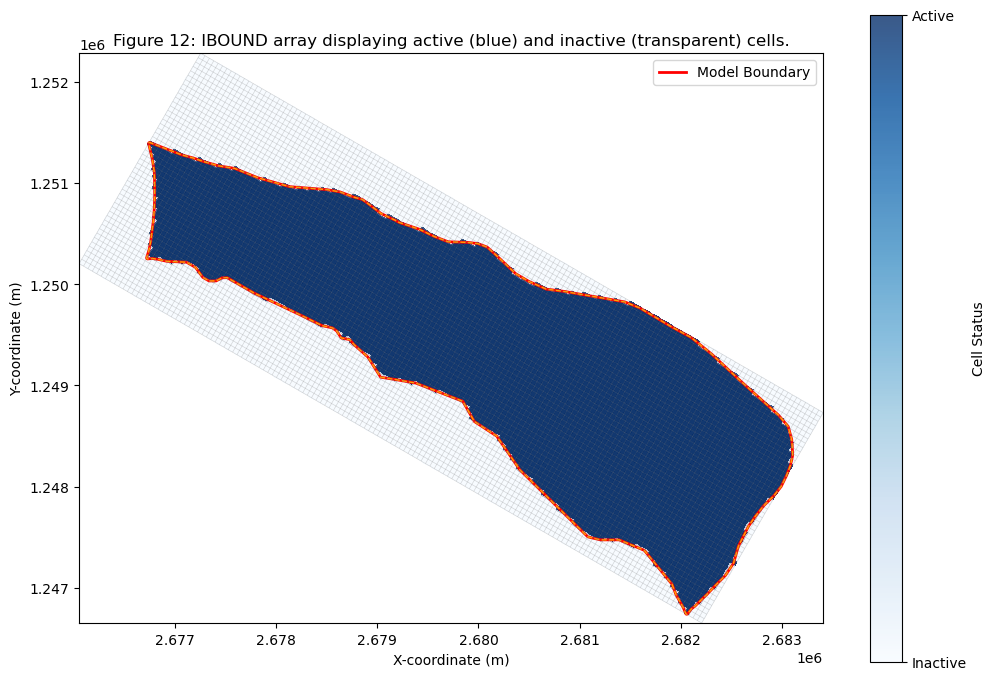


Refined IBOUND statistics (min thickness = 1.0m):
Cells deactivated due to thin aquifer: 0
Active cells: 4224
Inactive cells: 2592
Percentage active: 62.0%

BAS6 package created successfully with IBOUND array.
Model has 4224 active cells out of 6816 total cells

--- IBOUND Diagnostics ---
IBOUND diagnostics:
IBOUND shape: (1, 48, 142)
IBOUND layer 0 unique values: [0 1]
Active cells (ibound=1): 4224
Inactive cells (ibound=0): 2592
Other values: 0

Connectivity check:
Number of connected active regions: 1
IBOUND array exported to: /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model/ibound.gpkg


In [22]:
# --- 5. IBOUND Array Creation ---
# Create IBOUND array to define active/inactive cells
# Active cells (1) are inside the model boundary, inactive cells (0) are outside

# Initialize IBOUND array with all cells inactive (0)
ibound = np.zeros((nlay, nrow_rotated, ncol_rotated), dtype=int)

# Use the original model boundary (not buffered) for IBOUND
gdf_boundary = gdf.copy()  # Use the original model boundary (not buffered)

# Using GridIntersect (recommended for complex boundaries and rotated grids)
# Create a GridIntersect object
ix = GridIntersect(modelgrid, method='vertex', rtree=True)

# Get the intersection between the grid and the boundary polygon
# This returns the cells that intersect with the polygon
try:
    result = ix.intersect(gdf_boundary.geometry.union_all())
    
    # Extract the row and column indices of cells inside the boundary
    for idx, row in result.iterrows():
        ibound[0, row['row'], row['col']] = 1
        
    print("Successfully created IBOUND using GridIntersect method")
    
except Exception as e:
    print(f"GridIntersect method failed: {e}")
    print("Falling back to cell center method...")
    
    # Fallback Method: Using cell centers
    # Get cell centers
    xcenters = modelgrid.xcellcenters
    ycenters = modelgrid.ycellcenters
    
    # Get the boundary polygon
    boundary_polygon = gdf_boundary.geometry.union_all()
    
    # Check which cell centers are inside the boundary polygon
    for i in range(nrow_rotated):
        for j in range(ncol_rotated):
            point = Point(xcenters[i, j], ycenters[i, j])
            if boundary_polygon.contains(point):
                ibound[0, i, j] = 1

# Count active and inactive cells
active_cells = np.sum(ibound == 1)
inactive_cells = np.sum(ibound == 0)
print(f"\nInitial IBOUND statistics:")
print(f"Active cells: {active_cells}")
print(f"Inactive cells: {inactive_cells}")
print(f"Total cells: {active_cells + inactive_cells}")
print(f"Percentage active: {active_cells / (active_cells + inactive_cells) * 100:.1f}%")

# --- Visualization of IBOUND ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)

# Plot IBOUND array with custom colormap
# 0 = inactive (white), 1 = active (blue)
im = pmv.plot_array(ibound[0], cmap='Blues', vmin=0, vmax=1, alpha=0.8)
pmv.plot_grid(alpha=0.3, linewidth=0.5)

# Overlay the original boundary for verification
gdf_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Also overlay the buffered boundary to show the difference
gdf.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1, linestyle='--')

# Add colorbar
cbar = plt.colorbar(im, shrink=0.7, ticks=[0, 1])
cbar.ax.set_yticklabels(['Inactive', 'Active'])
cbar.set_label('Cell Status')

ax.set_title(f"Figure 12: IBOUND array displaying active (blue) and inactive (transparent) cells.")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal', adjustable='box')

# Create custom legend handles to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.legend(handles=[red_line])

plt.show()

# --- Optional: Refine IBOUND based on aquifer thickness ---
# You might want to deactivate cells where aquifer thickness is too small
min_thickness = 1.0  # meters

# Check if aquifer thickness is reasonable
thin_cells = aquifer_thickness_resampled < min_thickness

# Set cells with insufficient thickness to inactive
cells_deactivated = 0
for i in range(nrow_rotated):
    for j in range(ncol_rotated):
        if thin_cells[i, j] and ibound[0, i, j] == 1:
            ibound[0, i, j] = 0
            cells_deactivated += 1

# Update cell counts after refinement
active_cells_refined = np.sum(ibound == 1)
print(f"\nRefined IBOUND statistics (min thickness = {min_thickness}m):")
print(f"Cells deactivated due to thin aquifer: {cells_deactivated}")
print(f"Active cells: {active_cells_refined}")
print(f"Inactive cells: {np.sum(ibound == 0)}")
print(f"Percentage active: {active_cells_refined / (nrow_rotated * ncol_rotated) * 100:.1f}%")

# --- Add IBOUND to the BAS6 package ---
# Create the BAS6 package with the IBOUND array
# Use model_top as initial heads
bas = flopy.modflow.ModflowBas(
    mf, 
    ibound=ibound, 
    strt=model_top,
    hnoflo=-999.99  # Head value for no-flow cells
)

print("\nBAS6 package created successfully with IBOUND array.")
print(f"Model has {active_cells_refined} active cells out of {nrow_rotated * ncol_rotated} total cells")

# Diagnostic code to check IBOUND array
print("\n--- IBOUND Diagnostics ---")
print("IBOUND diagnostics:")
print(f"IBOUND shape: {ibound.shape}")
print(f"IBOUND layer 0 unique values: {np.unique(ibound[0])}")
print(f"Active cells (ibound=1): {np.sum(ibound[0] == 1)}")
print(f"Inactive cells (ibound=0): {np.sum(ibound[0] == 0)}")
print(f"Other values: {np.sum((ibound[0] != 0) & (ibound[0] != 1))}")

# Check a small sample of the IBOUND array
# print(f"Sample of IBOUND[0] values (first 5x5):")
# print(ibound[0][:5, :5])

''' Optional visualization code, uncomment to use
# --- Comprehensive Visualization ---
fig = plt.figure(figsize=(20, 15))

# Create a 2x2 subplot layout
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.2)

# Plot 1: Aquifer thickness
ax1 = fig.add_subplot(gs[0, 0])
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im1 = pmv1.plot_array(aquifer_thickness_resampled, alpha=0.8, cmap='viridis')
gdf_boundary.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im1, ax=ax1, shrink=0.7, label="Aquifer Thickness (m)")
ax1.set_title("Aquifer Thickness Distribution")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal', adjustable='box')

# Plot 2: IBOUND with inactive cells highlighted
ax2 = fig.add_subplot(gs[0, 1])
pmv2 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax2)
im2 = pmv2.plot_array(ibound[0], cmap='RdBu_r', vmin=0, vmax=1, alpha=0.8)
gdf_boundary.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=2)
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.7, ticks=[0, 1])
cbar2.ax.set_yticklabels(['Inactive', 'Active'])
cbar2.set_label('Cell Status')
ax2.set_title("Final IBOUND Array")
ax2.set_xlabel("X-coordinate (m)")
ax2.set_ylabel("Y-coordinate (m)")
ax2.set_aspect('equal', adjustable='box')

# Plot 3: Combined view - thickness with inactive cells overlay
ax3 = fig.add_subplot(gs[1, 0])
pmv3 = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax3)
im3 = pmv3.plot_array(aquifer_thickness_resampled, alpha=0.6, cmap='viridis', 
                      edgecolor='none', linewidth=0)
pmv3.plot_inactive(color='gray', alpha=0.8, edgecolor='none', linewidth=0)
plt.colorbar(im3, ax=ax3, shrink=0.7, label="Aquifer Thickness (m)")
ax3.set_title("Aquifer Thickness with Inactive Cells (gray)")
ax3.set_xlabel("X-coordinate (m)")
ax3.set_ylabel("Y-coordinate (m)")
ax3.set_aspect('equal', adjustable='box')

# Plot 4: Model top elevation with IBOUND
ax4 = fig.add_subplot(gs[1, 1])
pmv4 = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax4)
im4 = pmv4.plot_array(model_top, alpha=0.6, cmap='terrain', edgecolor='none', 
                      linewidth=0)
pmv4.plot_inactive(color='white', alpha=0.8, edgecolor='none', linewidth=0)
plt.colorbar(im4, ax=ax4, shrink=0.7, label="Elevation (m a.s.l.)")
ax4.set_title("Model Top Elevation with Active Domain")
ax4.set_xlabel("X-coordinate (m)")
ax4.set_ylabel("Y-coordinate (m)")
ax4.set_aspect('equal', adjustable='box')

plt.suptitle(f"IBOUND Analysis for Rotated Grid (Rotation: {grid_rotation_angle}°)", fontsize=16)

# Use subplots_adjust instead of tight_layout to avoid warnings
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=0.95, hspace=0.3, wspace=0.2)
plt.show()
'''

# --- Quality Check: Edge cells ---
# Check for isolated active cells (might indicate issues)
from scipy import ndimage

# Label connected components
labeled_array, num_features = ndimage.label(ibound[0])

print(f"\nConnectivity check:")
print(f"Number of connected active regions: {num_features}")
if num_features > 1:
    print("Warning: Multiple disconnected active regions detected!")
    # Count cells in each region
    for i in range(1, num_features + 1):
        region_size = np.sum(labeled_array == i)
        print(f"  Region {i}: {region_size} cells")

# Save the ibound array to a file for later use
ibound_file_path = os.path.join(workspace, 'ibound.npy')
np.save(ibound_file_path, ibound)

# Save the ibound array to a GeoDataFrame for visualization
ibound_cells = []
for i in range(nrow_rotated):
    for j in range(ncol_rotated):
        cell_polygon = modelgrid.get_cell_vertices(i, j)
        ibound_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': Polygon(cell_polygon),
            'ibound': int(ibound[0, i, j]),
            'x': modelgrid.xcellcenters[i, j],
            'y': modelgrid.ycellcenters[i, j]
        })  
# Create GeoDataFrame
ibound_gdf = gpd.GeoDataFrame(ibound_cells, crs=modelgrid.crs)  
# Export to GeoPackage
ibound_geopackage_path = os.path.join(workspace, 'ibound.gpkg')
ibound_gdf.to_file(ibound_geopackage_path, driver='GPKG', layer='ibound')

print(f"IBOUND array exported to: {ibound_geopackage_path}")

In [ ]:
create_model_implementation_step_completion_marker(5)

## Layer-Property Flow (LPF) Package

We also define the **Layer-Property Flow (LPF) Package**, where we assign hydraulic properties. As a first estimate, we'll use a uniform hydraulic conductivity based on literature values for gravel aquifers, as seen in Notebook 2.

We do not have any detailed information about the hydraulic conductivity of the aquifer. We start out with a uniform hydraulic conductivity of 10 m/d, which is a typical value for gravel aquifers. We might assign zones of different hydraulic conductivities later during model calibration. We will also assume a uniform specific storage of 1e-5 1/m and a uniform specific yield of 0.15. Figure 13 shows the hydraulic conductivity field of the model.

Please note that the wetting parameters are defined in the LPF package. They are not strictly necessary for a basic model, but can be useful for more complex models with transient conditions. The wetting parameters control the re-wetting of cells in the model. 

Setting up Layer Properties (LPF) Package with uniform values...

LPF package created successfully with uniform properties:
Horizontal hydraulic conductivity: 10.0 m/day
Vertical hydraulic conductivity: 1.0 m/day
Specific yield: 0.15
Specific storage: 1e-05 1/m
Layer type: Convertible (unconfined)


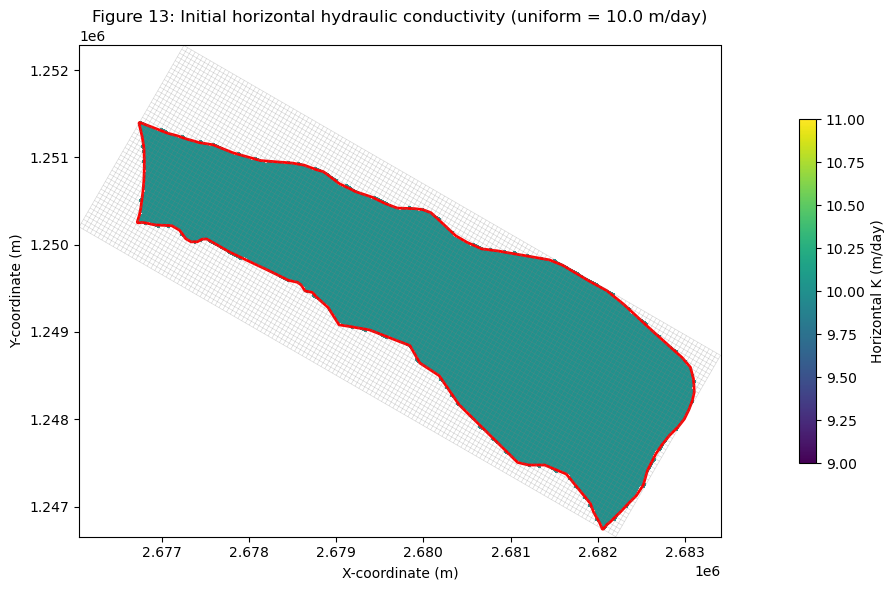


Uniform K fields saved to /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model


In [23]:
# --- 6. Layer Properties (LPF Package) ---
print("Setting up Layer Properties (LPF) Package with uniform values...")

# Uniform hydraulic conductivity values
# Typical for sandy gravel aquifers in Swiss valleys
hk_uniform = 10.0  # m/day - horizontal hydraulic conductivity
vk_uniform = 1.0   # m/day - vertical hydraulic conductivity (typically Kh/10)

# Create uniform K arrays
hk = np.ones((nlay, nrow_rotated, ncol_rotated)) * hk_uniform
vk = np.ones((nlay, nrow_rotated, ncol_rotated)) * vk_uniform

# Set K to 0 for inactive cells
hk[ibound == 0] = 0
vk[ibound == 0] = 0

# Storage properties (uniform)
sy = 0.15  # Specific yield (typical for unconfined sandy gravel aquifers)
ss = 1e-5  # Specific storage (1/m) (typical value)

# Layer type (0 = confined, 1 = convertible/unconfined)
# Limmat valley aquifer is unconfined
laytyp = 1

# Create the LPF package
lpf = flopy.modflow.ModflowLpf(
    mf,
    hk=hk,                  # Horizontal hydraulic conductivity
    vka=vk,                 # Vertical hydraulic conductivity
    sy=sy,                  # Specific yield
    ss=ss,                  # Specific storage
    laytyp=laytyp,          # Layer type (1 = convertible/unconfined)
    ipakcb=53,              # Unit number for cell-by-cell budget file
    hdry=-999.99,           # Head assigned to dry cells
    wetfct=0.1,             # Wetting factor
    iwetit=1,               # Wetting iteration interval
    laywet=1                # Flag indicating if wetting is active for each layer
)

print("\nLPF package created successfully with uniform properties:")
print(f"Horizontal hydraulic conductivity: {hk_uniform} m/day")
print(f"Vertical hydraulic conductivity: {vk_uniform} m/day")
print(f"Specific yield: {sy}")
print(f"Specific storage: {ss} 1/m")
print(f"Layer type: {'Convertible (unconfined)' if laytyp == 1 else 'Confined'}")

# Quick visualization of the uniform K field
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Plot horizontal K
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im1 = pmv1.plot_array(hk[0], masked_values=[0])
#pmv1.plot_inactive(ibound[0], color='gray', alpha=0.8)
pmv1.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
cb1 = plt.colorbar(im1, ax=ax1, shrink=0.7)
cb1.set_label("Horizontal K (m/day)")
ax1.set_title(f"Figure 13: Initial horizontal hydraulic conductivity (uniform = {hk_uniform} m/day)")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal')

plt.tight_layout()
plt.show()

# Save the uniform K field for reference
np.save(os.path.join(workspace, 'uniform_hk_field.npy'), hk)
np.save(os.path.join(workspace, 'uniform_vk_field.npy'), vk)
print(f"\nUniform K fields saved to {workspace}")

In [ ]:
create_model_implementation_step_completion_marker(6)

## Solver and Output Control (PCG & OC Packages)

We need to tell MODFLOW how to solve the system of equations. The **Preconditioned Conjugate-Gradient (PCG)** package is a robust and commonly used solver. We also need to specify what results we want to save using the **Output Control (OC)** package. We are interested in saving the head and budget results.

In [24]:
# --- 7. Solver and Output Control ---
# Add the PCG solver
pcg = flopy.modflow.ModflowPcg(mf, mxiter=50, iter1=30)

# Specify output control
oc = flopy.modflow.ModflowOc(
    mf, 
    # Save head and budget at the end of each stress period
    stress_period_data={(0, 0): ['save head', 'save budget']}
)

Now we have the model geometry and the initial parameterization set up. As you will have noticed, many assumptions and simplifications have already gone into this step. We'll continue straight away with more assumptions when we implement the model forcing in the following steps.   

We start out with the simplest one: **Flow through the aquifer bottom**. As the thickness of the aquifer is known, we can assume that the flow through the aquifer bottom is negligible. This means that we do not need to implement a flow through the aquifer bottom in the model. 

- inflow through the aquifer bottom is zero

We don't need to implement anything as per default, the boundaries of the model are impermeable in modflow.

In [ ]:
create_model_implementation_step_completion_marker(7)

## Net Areal Recharge (RCH Package)

Next, we tackle the **recharge from the top**: In the perceptual model chapter, we found that about 110 mm/year of net recharge is expected in the Limmat Valley. We will implement this as a uniform recharge across the model area. We defined the stress period length as 1 day, so we need to convert the annual recharge rate to a daily recharge rate. 


In [25]:
# --- 8. Areal Recharge ---
# Average net recharge value for the Limmat valley: 110 mm/year
rech_value = 0.110 / 365.25  # m/day
rech_array = np.full((nrow_rotated, ncol_rotated), rech_value, dtype=float)

rch = flopy.modflow.ModflowRch(
    mf, 
    rech=rech_array, 
    nrchop=1  # 1 = constant rate
)

print("\nAreal recharge package created with constant rate:")
print(f"Recharge value: {rech_value:.6f} m/day")


Areal recharge package created with constant rate:
Recharge value: 0.000301 m/day


In [ ]:
create_model_implementation_step_completion_marker(8)

## Lateral in- and outflows 
We use a no-inflow boundary in the south-east, so we do not have to do anything there. In the north-west, we define a fixed-head outflow boundary. This means that we will set a fixed head value for the cells along the north-west boundary. The head value will be based on the long-term average value of piezometer 481 (see Chapter 2 - Perceptual Model) which is 390 m a.s.l. We use the constant head boundary condition (CHD) to implement this fixed-head outflow boundary.  

The most straight forward way to select the cells with constant head is to load the IBOUND shape in QGIS and select the cells along the western boundary. See printscreen of QGIS in Figure 14. The selected features can then be exported as a shapefile and loaded into the notebook. The code below shows how to create the constant head boundary condition based on the selected cells.

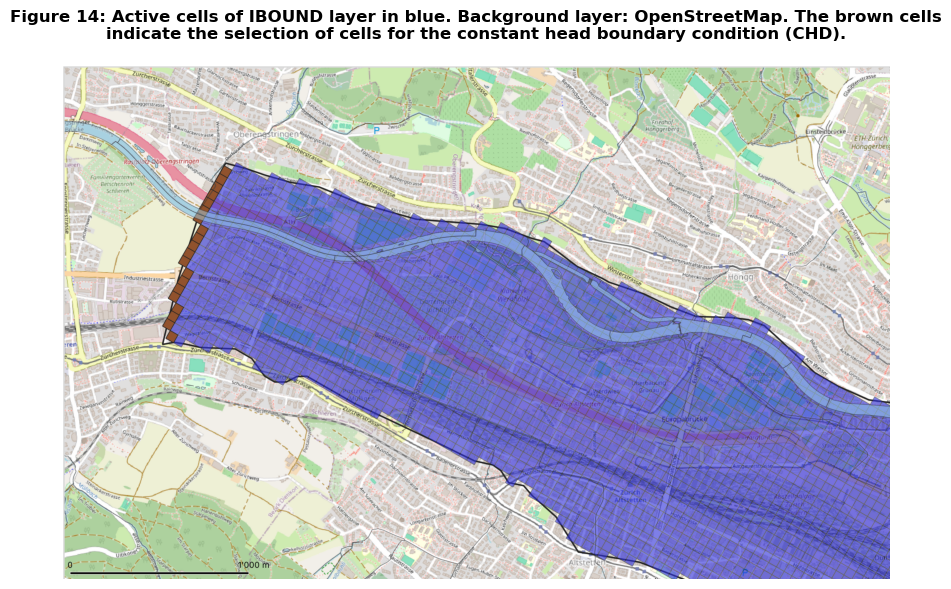

In [26]:
display_image(
    image_filename='selection_of_cells_for_chd_boundary_qgis.png', 
    image_folder='4_model_implementation',
    caption='Figure 14: Active cells of IBOUND layer in blue. Background layer: OpenStreetMap. The brown cells indicate the selection of cells for the constant head boundary condition (CHD).'
)

In [ ]:
# --- 9. Constant Head Boundary ---
# Load the cell selection for the constant head boundary. 
chd_cells_path = download_named_file(
    name='chd_cells', 
    data_type='gis'
)

# Load CHD selection layer (assumes it only contains desired CHD cells)
chd_sel = gpd.read_file(chd_cells_path)
chd_sel = chd_sel.to_crs(modelgrid.crs)

# Reuse ibound_gdf (created earlier) as grid reference
if 'ibound_gdf' not in globals():
    raise RuntimeError("ibound_gdf not found. Ensure the IBOUND section was executed.")

# Ensure required columns
required_cols = {'cell_id', 'row', 'col'}
missing = required_cols - set(ibound_gdf.columns)
if missing:
    raise ValueError(f"ibound_gdf is missing required columns: {missing}")

if 'cell_id' not in chd_sel.columns:
    raise ValueError("CHD selection layer lacks 'cell_id'. Add it (e.g., from IBOUND export) and retry.")

# Normalize cell_id
chd_sel['cell_id'] = chd_sel['cell_id'].astype(str).str.strip()
ibound_gdf['cell_id'] = ibound_gdf['cell_id'].astype(str).str.strip()

# Join on cell_id
chd_join = chd_sel.merge(
    ibound_gdf[['cell_id']],
    on='cell_id',
    how='inner',
    validate='1:1'
)

if chd_join.empty:
    raise ValueError("No matching cell_id between CHD layer and ibound_gdf.")

# Vector filter to active cells
rows = chd_join['row'].astype(int).to_numpy()
cols = chd_join['col'].astype(int).to_numpy()
active_mask = ibound[0, rows, cols] == 1
chd_active = chd_join.loc[active_mask].drop_duplicates(subset=['row', 'col'])

if chd_active.empty:
    raise ValueError("Selected CHD cells are not active (ibound==1).")

# Assign constant head value
const_head_value = 390.0

# Set ibound to -1 for CHD cells
for r, c in zip(chd_active['row'].astype(int), chd_active['col'].astype(int)):
    ibound[0, r, c] = -1

# Update BAS package with modified ibound (recreate to be safe)
bas = flopy.modflow.ModflowBas(
    mf,
    ibound=ibound,
    strt=model_top,
    hnoflo=-999.99
)

# Build CHD stress period data
chd_cells = [
    [0, int(r), int(c), const_head_value, const_head_value]
    for r, c in zip(chd_active['row'], chd_active['col'])
]

print(f"Number of CHD cells (from selection layer): {len(chd_cells)}")

# Build stress period data for constant head
chd = flopy.modflow.ModflowChd(
    mf,
    stress_period_data={0: chd_cells},
)

print("\nConstant head boundary package created with constant heads:")
print(f"Constant head value: {const_head_value} m")

# Plot the cells with constant head
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
im = pmv.plot_bc(package=chd, color='blue', alpha=0.8, vmin=const_head_value, 
                 vmax=const_head_value)
pmv.plot_inactive(ibound[0], color='gray', alpha=0.8)
pmv.plot_grid(alpha=0.3, linewidth=0.2)
plt.colorbar(im, ax=ax, shrink=0.7, label="Constant Head (m)")
ax.set_title("Figure 15: Constant head boundary cells in blue.")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal')

plt.show()

In Figure 15, you can see the constant head boundary cells in blue. The cells are set to a fixed head value of 390 m a.s.l. and the IBOUND is set to -1 for these cells. This means that the model will maintain this head value in these cells throughout the simulation.  

Next we tackle the **lateral inflows from the north and the south** of the model. We will implement these as recharge wells with specified rates. In Chapter 2 - Perceptual Model, we estimate the lateral inflows to be about 20% of the annual precipiation of 1100 mm/year on an area of 11 km2 in the north and 15 km2 in the south. These amounts have to be distributed along the northern and southern boundaries of the model. We will do the same trick with the selection of cells for in QGIS as for the constant head boundary condition. The code below shows how to create the lateral inflow boundary condition based on the selected cells.

In [ ]:
# --- 10. Lateral Inflow via WEL package --- 
# Each selected boundary cell receives an equal share of the total inflow
# Positive WEL rates inject water (MODFLOW convention)
inflow_north = 0.2 * 1.100 * 11000000 / 365.25  # m3/day
inflow_south = 0.2 * 1.100 * 15000000 / 365.25  # m3/day

wells_north_path = download_named_file(
    name='wells_north', 
    data_type='gis'
)
wells_south_path = download_named_file(
    name='wells_south', 
    data_type='gis'
)

# Load selections
wells_north_gdf = gpd.read_file(wells_north_path).to_crs(modelgrid.crs)
wells_south_gdf = gpd.read_file(wells_south_path).to_crs(modelgrid.crs)

if 'ibound_gdf' not in globals():
    raise RuntimeError("ibound_gdf not in scope. Run IBOUND section first.")

for need in ['cell_id', 'row', 'col', 'ibound']:
    if need not in ibound_gdf.columns:
        raise ValueError(f"ibound_gdf missing column: {need}")

for g in (wells_north_gdf, wells_south_gdf):
    if 'cell_id' not in g.columns:
        raise ValueError("Boundary well selection layers must contain 'cell_id' (export from ibound layer).")

# Normalize identifiers
ibound_gdf['cell_id'] = ibound_gdf['cell_id'].astype(str).str.strip()
wells_north_gdf['cell_id'] = wells_north_gdf['cell_id'].astype(str).str.strip()
wells_south_gdf['cell_id'] = wells_south_gdf['cell_id'].astype(str).str.strip()

def prepare_boundary(df_sel, label):
    joined = df_sel.merge(
        ibound_gdf[['cell_id']],
        on='cell_id',
        how='inner',
        validate='1:1'
    )
    if joined.empty:
        raise ValueError(f"No matching cell_id for {label} boundary selection.")
    # Keep active (ibound==1) only (exclude inactive and CHD cells)
    joined = joined.loc[joined['ibound'] == 1].drop_duplicates(subset=['row','col'])
    joined['row'] = joined['row'].astype(int)
    joined['col'] = joined['col'].astype(int)
    return joined

north_cells = prepare_boundary(wells_north_gdf, "north")
south_cells = prepare_boundary(wells_south_gdf, "south")

n_north = len(north_cells)
n_south = len(south_cells)

if n_north == 0:
    raise ValueError("North boundary selection has no active non-CHD cells.")
if n_south == 0:
    raise ValueError("South boundary selection has no active non-CHD cells.")

# Distribute uniformly
q_north_each = inflow_north / n_north
q_south_each = inflow_south / n_south

# Build stress period data list: [lay, row, col, flux]
wel_spd = []
for _, r in north_cells.iterrows():
    wel_spd.append([0, r.row, r.col, q_north_each])
for _, r in south_cells.iterrows():
    wel_spd.append([0, r.row, r.col, q_south_each])

total_assigned = sum(w[3] for w in wel_spd)
print(f"Lateral inflow north total: {inflow_north:.2f} m3/d over {n_north} cells "
      f"(each {q_north_each:.3f} m3/d)")
print(f"Lateral inflow south total: {inflow_south:.2f} m3/d over {n_south} cells "
      f"(each {q_south_each:.3f} m3/d)")
print(f"Combined injected via WEL: {total_assigned:.2f} m3/d")

# Create / replace WEL package
wel = flopy.modflow.ModflowWel(
    mf,
    stress_period_data={0: wel_spd},
    ipakcb=53
)

print("WEL package created for lateral inflows.")

# Plot wells
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid(alpha=0.2, linewidth=0.4)
pmv.plot_array(model_top, alpha=0.35, cmap='terrain')
# Symbol size scaled (simple)
for qlist, color, label in [(north_cells, 'cyan', 'North inflow cell'),
                            (south_cells, 'magenta', 'South inflow cell')]:
    ax.scatter(
        modelgrid.xcellcenters[qlist['row'], qlist['col']],
        modelgrid.ycellcenters[qlist['row'], qlist['col']],
        c=color, s=50, edgecolors='k', linewidths=0.4, label=label
    )
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ax.set_title("Figure 16: Lateral inflow cells (WEL) forming the northern and southern inflow boundaries. The model boundary is shown in red. The background is the model top elevation.")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect('equal')
ax.legend()
plt.show()

# Quick check: ensure no CHD overlap
overlap = []
if 'chd' in globals():
    chd_cells_set = {(c[1], c[2]) for c in chd.stress_period_data[0]}
    for w in wel_spd:
        if (w[1], w[2]) in chd_cells_set:
            overlap.append((w[1], w[2]))
if overlap:
    print(f"Warning: {len(overlap)} WEL cells overlap CHD cells (they will be ignored by MODFLOW).")



We now have all lateral in- and outflows implemented in the model (Figure 16). What remains is to implement the **river-aquifer interaction**. 

In [ ]:
create_model_implementation_step_completion_marker(9)

## River Interaction (RIV Package)

Now we implement the river. First, we get the river layer by the Canton of Zurich. we only keep the river layers in the model domain. We further discard the smaller rivers because we do not have any information about them and we assume that they are not contributing significantly to the groundwater flow in the Limmat Valley (see Figure 17). 

We'll further have to assume a bottom elevation of the river as river profiles are not publicly available. We will linearly interpolate the river bottom elevation based an assumed average river depth for each river. 

Please note that in a paid project, you would optimally get access to more detailed river profile data. River profile data is available for the river stretches which are relevant for flood management. As a modeler, you will have to remember to ask your client for this data. However, in many parts of the world, river profile data is not available and you will have to make many assumptions about the river-aquifer interaction.   

In [ ]:
# --- 11. River Data ---
# Get the path to the river shapes and to the boundary outline
river_data_path = download_named_file(name='rivers', data_type='gis')
boundary_path = download_named_file(name='model_boundary', data_type='gis')

# Intersect the river data with the model grid and only keep the parts that are 
# inside the model boundary. 
river_gdf = gpd.read_file(river_data_path)
boundary_gdf = gpd.read_file(boundary_path)
# Ensure both GeoDataFrames are in the same CRS
river_gdf = river_gdf.to_crs(modelgrid.crs)
boundary_gdf = boundary_gdf.to_crs(modelgrid.crs)
# Clip the river data to the model boundary
river_clipped = gpd.clip(river_gdf, boundary_gdf)

# Print the column names of the clipped river data to understand its structure
print("Clipped river data columns:")
print(river_clipped.columns)
# Print the unique values in the 'GEWAESSERNAME' column to understand the river names
print("\nUnique river names in the clipped data:")
print(river_clipped['GEWAESSERNAME'].unique())

# We are interested in the river sections belonging to the rivers Sihl and Limmat. 
# We will further keep the canal in the north of the Werdinsel. This canal does 
# not have a name in the river data, but we can identify it through the geometry 
# and the unique OBJID. 
river_clipped = river_clipped[
    (river_clipped['GEWAESSERNAME'].isin(['Sihl', 'Limmat'])) |
    (river_clipped['OBJID'].isin(['32998', '34996', '37804', '95527']))
]

# Plot the clipped river data to verify
fig, ax = plt.subplots(figsize=(12, 12))
river_clipped.plot(ax=ax, color='blue', linewidth=2, label='Clipped River Data')
blue_polygon = mpatches.Patch(facecolor='blue', linewidth=2, label='Clipped River Data')
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.set_title("Figure 17: Clipped river data within the model boundary. ")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
ax.legend(handles=[blue_polygon, red_line])
plt.show()

Now let's check if the elevation of the gauges on the river are consistent with the DEM. If the DEM is coarse and the river is narrow, the DEM might not capture the river elevation correctly. In this case, we might have to revert to a higher-resolution DEM that captures the river elevation better. If a higher-resolution DEM is not available, we can will have to carefully review the river elevation and adjust it manually if necessary. This will, in turn, make a bias correction of the river stage measurements necessary.

In [ ]:
print("Summarizing river data ...")

# Load gauge locations
gauges_path = download_named_file(name='gauges', data_type='gis')
gauges_gdf = gpd.read_file(gauges_path, layer="GS_LIMNIGRAPHENSTATIONEN_P")
gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)

# Keep only the gauges in the model area
gauges_gdf = gauges_gdf[gauges_gdf.geometry.within(gdf_boundary.union_all())]

# print("\nGauge information:")
# print(gauges_gdf[['LABEL', 'NAME']].head())

# We extracted the average river stage values from the gauges in 
# `2_perceptual_model.ipynb`. Let's use these values to check if the river stage
# is reasonable. The average river stage values are: 
river_data_path = os.path.join('case_study_zurich', 'data', 'rivers', 'river_data_summary.npy')
river_stage_summary = np.load(river_data_path, allow_pickle=True).item()
# Print the river stage summary to understand the values
# print("\nRiver stage summary:")
# print(river_stage_summary)
# The river stage summary is a nested dictionary with river names as keys and 
# with names of statistics as secondary key. We replace the river names with the 
# gauge labels to make it easier to match with the gauges.
# Create a mapping from river labels to river names in the river stage summary
label_to_river = {
    'LH  2099': 'limmat', 
    'LH  2176': 'sihl',
}
# Add 'mean' for each gauge to the gauges_gdf using the correct mapping
gauges_gdf['mean_stage_masl'] = gauges_gdf['LABEL'].map(
    lambda x: river_stage_summary.get(label_to_river.get(x, ''), {}).get('mean', np.nan)
)
# Round mean river stage values to 2 decimal places
gauges_gdf['mean_stage_masl'] = gauges_gdf['mean_stage_masl'].round(2)

# Print the updated gauges_gdf to verify
# print("\nUpdated gauges_gdf with mean river stage:")
# print(gauges_gdf[['LABEL', 'NAME', 'mean_stage_masl']])

# print("\nExtracting model_top values at gauge locations...")
# Check if gauges_gdf and mf.modelgrid have the same CRS
if gauges_gdf.crs != modelgrid.crs:
    print("Warning: CRS mismatch between gauges_gdf and modelgrid. Reprojecting...")
    gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)
# Print coordinates of gauges and model grid extent for debugging
# print("\nGauge coordinates:")
# for idx, gauge in gauges_gdf.iterrows():
#     print(f"Gauge {gauge['LABEL']} at ({gauge.geometry.centroid.x:.2f}, {gauge.geometry.centroid.y:.2f})")
# print("\nModel grid extent:")
# print(f"X range: {modelgrid.xcellcenters.min():.2f} to {modelgrid.xcellcenters.max():.2f}")
# print(f"Y range: {modelgrid.ycellcenters.min():.2f} to {modelgrid.ycellcenters.max():.2f}")

# Check if each gauge is within the model grid extent
# print("\nChecking if each gauge is within model grid extent:")
for idx, gauge in gauges_gdf.iterrows():
    gauge_x = gauge.geometry.x
    gauge_y = gauge.geometry.y
    
    xlim = (gauge_x > modelgrid.xcellcenters.min()) & (gauge_x < modelgrid.xcellcenters.max())
    ylim = (gauge_y > modelgrid.ycellcenters.min()) & (gauge_y < modelgrid.ycellcenters.max())
    
    within_bounds = xlim and ylim
    if not within_bounds:
        print(f"  WARNING: Gauge {gauge['LABEL']} is outside the model grid extent!")

# Create a GridIntersect object
ix = GridIntersect(modelgrid, method='vertex')

# Get model top values at gauge locations
model_top_at_gauges = []
gauge_cell_info = []

("\nUsing nearest neighbor approach for all gauges:")
for idx, gauge in gauges_gdf.iterrows():
    gauge_x, gauge_y = gauge.geometry.x, gauge.geometry.y
    
    # Calculate distances to all cell centers
    x_centers = modelgrid.xcellcenters
    y_centers = modelgrid.ycellcenters
    
    distances = np.sqrt((x_centers - gauge_x)**2 + (y_centers - gauge_y)**2)
    
    # Find the cell with minimum distance
    min_row, min_col = np.unravel_index(distances.argmin(), distances.shape)
    min_distance = distances[min_row, min_col]
    
    # Check if this cell is active
    is_active = ibound[0, min_row, min_col] == 1
    
    # Get the model top value at this cell
    top_value = modelgrid.top[min_row, min_col]
    
    # Add this to the dataframe
    gauges_gdf.loc[idx, 'model_top_masl'] = top_value

print("\nUpdated gauges_gdf with model top:")
print(gauges_gdf[['LABEL', 'NAME', 'mean_stage_masl', 'model_top_masl']])

We see that the gauge level of the river Sihl is above the model top. For the river Limmat, we're ok. 

We have several options now:   
- Resample the model top from a higher-resolution DEM (way to go if a higher-resolution DEM is availble)
- Manually bias-correct the time series of the river water level in the river Sihl to be consistent with the model top (tedious but doable)
- Manually increase the DEM in the south-east corner of the model (last resort)

In the case of the Limmat valley aquifer, a higher resolution DEM is indeed available. The swissALTI3D model from the Swiss Federal Office of Topography (swisstopo), see Figure 18. If you are interested in how to download the DEM and to merge the tiles, please refer to the `processing_DEM.ipynb` in `SUPPPORT_REPO/src/scripts/scripts_limmat_data_preprocessing/`. 

In [ ]:
# Load the high-resolution DEM data
dem_path = download_named_file(
    name='dem_hres',
    data_type='gis'
)

# Check CRS compatibility first
with rasterio.open(dem_path) as src:
    dem_crs = src.crs
    print(f"DEM CRS: {dem_crs}")
    print(f"Model grid CRS: {modelgrid.crs}")
    
    if str(dem_crs) != str(modelgrid.crs):
        print("CRS transformation needed")
        
        # Get the bounds of the model grid in its CRS
        grid_bounds = modelgrid.extent
        
        # Transform model grid bounds to DEM CRS for cropping
        dem_bounds = transform_bounds(
            modelgrid.crs, dem_crs, 
            grid_bounds[0], grid_bounds[2], 
            grid_bounds[1], grid_bounds[3]
        )
        
        # Read and crop the DEM data
        window = src.window(*dem_bounds)
        dem_data = src.read(1, window=window)
        dem_transform = src.window_transform(window)
        
        # Now reproject the cropped DEM to match the model grid CRS
        dst_crs = modelgrid.crs
        dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
            dem_crs, dst_crs, dem_data.shape[1], dem_data.shape[0], *dem_bounds
        )
        
        # Create output array
        reprojected_dem = np.empty((dst_height, dst_width), dtype=dem_data.dtype)
        
        # Perform the reprojection
        reproject(
            dem_data,
            reprojected_dem,
            src_transform=dem_transform,
            src_crs=dem_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )
        
        # Create a temporary raster file with the reprojected data
        import tempfile
        with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmp:
            tmp_path = tmp.name
            
        with rasterio.open(
            tmp_path, 'w',
            driver='GTiff',
            height=dst_height,
            width=dst_width,
            count=1,
            dtype=reprojected_dem.dtype,
            crs=dst_crs,
            transform=dst_transform,
        ) as dst:
            dst.write(reprojected_dem, 1)
        
        # Now load with FloPy Raster
        rio = Raster.load(tmp_path)
        
        # Clean up temporary file
        import os
        os.unlink(tmp_path)
        
    else:
        print("CRS are compatible, no transformation needed")
        rio = Raster.load(dem_path)

arr = rio.get_array(1)
# Mask values below 0 and set them to NaN
arr = np.where(arr <= 0, np.nan, arr)

idx = np.isfinite(arr)

vmin, vmax = arr[idx].min(), arr[idx].max()
print(f"DEM elevation range: {vmin:.1f} to {vmax:.1f} meters")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a masked array for plotting to handle NaN values properly
masked_arr = np.ma.masked_invalid(arr)

# Plot the raster with proper extent
im = ax.imshow(masked_arr, extent=rio.bounds, vmin=vmin, vmax=vmax, cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Elevation (m)")

# Plot the model grid on top
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid(lw=0.5, color="white", alpha=0.7)
gdf_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ax.set_title("Figure 18: High-resolution DEM with model grid overlay in grey and model boundary in red.")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
plt.tight_layout()
plt.show()


Let's see if this high-resolution DEM can help us to resolve the river elevation issue. We will load the high-resolution DEM and compare it to the model top and the river gauge elevations. 

In [ ]:
# Load the high-resolution DEM (2m grid)
dem_path = download_named_file(name='dem_hres', data_type='gis')
dem_raster = Raster.load(dem_path)

# Load river shapes
rivers_path = download_named_file(name='rivers', data_type='gis')
rivers_gdf = gpd.read_file(rivers_path)
rivers_gdf = rivers_gdf.to_crs(dem_raster.crs)

# Load gauge locations
gauges_path = download_named_file(name='gauges', data_type='gis')
gauges_gdf = gpd.read_file(gauges_path, layer='GS_LIMNIGRAPHENSTATIONEN_P')
gauges_gdf = gauges_gdf.to_crs(dem_raster.crs)

# Known gauge stages (average values)
gauge_stages = {
    'Sihl': 412.347,    # m a.s.l.
    'Limmat': 400.285   # m a.s.l.
}

# Get DEM array and extent
dem_array = dem_raster.get_array(1)
dem_bounds = dem_raster.bounds
dem_transform = dem_raster.transform

# Create figure with subplots for each gauge
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Define buffer distance around gauges (in meters)
buffer_distance = 100  # 100m radius around gauge

for idx, (river_name, stage) in enumerate(gauge_stages.items()):
    ax = axes[idx]
    
    # Find gauge location
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    
    if len(river_gauges) > 0:
        gauge = river_gauges.iloc[0]
        gauge_x = gauge.geometry.x
        gauge_y = gauge.geometry.y
        
        # Create buffer around gauge
        gauge_buffer = gauge.geometry.buffer(buffer_distance)
        
        # Convert coordinates to pixel indices using the transform
        from rasterio.transform import rowcol
        
        # Get buffer bounds
        buffer_bounds = gauge_buffer.bounds
        
        # Convert bounds to row/col
        row_min, col_min = rowcol(dem_transform, buffer_bounds[0], buffer_bounds[3])
        row_max, col_max = rowcol(dem_transform, buffer_bounds[2], buffer_bounds[1])
        
        # Ensure indices are within bounds
        row_min = max(0, row_min)
        row_max = min(dem_array.shape[0], row_max)
        col_min = max(0, col_min)
        col_max = min(dem_array.shape[1], col_max)
        
        # Extract DEM subset
        dem_subset = dem_array[row_min:row_max, col_min:col_max]
        
        # Calculate extent for subset using transform
        from rasterio.transform import xy
        xmin, ymax = xy(dem_transform, row_min, col_min)
        xmax, ymin = xy(dem_transform, row_max, col_max)
        subset_extent = [xmin, xmax, ymin, ymax]
        
        # Plot DEM subset
        im = ax.imshow(dem_subset, extent=subset_extent, cmap='terrain', 
                       origin='upper', alpha=0.8)
        
        # Add contour lines
        X = np.linspace(subset_extent[0], subset_extent[1], dem_subset.shape[1])
        Y = np.linspace(subset_extent[3], subset_extent[2], dem_subset.shape[0])
        XX, YY = np.meshgrid(X, Y)
        contours = ax.contour(XX, YY, dem_subset, levels=10, colors='black', 
                             alpha=0.3, linewidths=0.5)
        ax.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
        
        # Plot river sections within view
        rivers_clip = gpd.clip(rivers_gdf, gauge_buffer)
        if len(rivers_clip) > 0:
            rivers_clip.plot(ax=ax, color='blue', linewidth=3, label='River')
        
        # Plot gauge location
        ax.scatter(gauge_x, gauge_y, color='red', s=200, marker='o', 
                  edgecolor='black', linewidth=2, zorder=10, 
                  label=f'{river_name} Gauge')
        
        # Extract DEM values along a cross-section through the gauge
        # Create points along x-axis at gauge y-coordinate
        cross_x = np.linspace(subset_extent[0], subset_extent[1], 50)
        cross_y = np.full_like(cross_x, gauge_y)
        
        # Sample DEM at these points
        cross_dem = []
        for x, y in zip(cross_x, cross_y):
            row, col = rowcol(dem_transform, x, y)
            if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
                cross_dem.append(dem_array[row, col])
            else:
                cross_dem.append(np.nan)
        
        # Set up twin axis for elevation profile
        ax_twin = ax.twinx()
        ax_twin.plot(cross_x, cross_dem, 'k-', linewidth=2, alpha=0.7, 
                    label='DEM Profile')
        ax_twin.axhline(y=stage, color='red', linewidth=2, 
                       label=f'River Stage')
        ax_twin.set_ylabel('Elevation (m a.s.l.)')
        ax_twin.set_ylim(min(np.nanmin(cross_dem) - 5, stage - 5), 
                        max(np.nanmax(cross_dem) + 5, stage + 5))
        
        # Colorbar for DEM
        cbar = plt.colorbar(im, ax=ax, pad=0.15)
        cbar.set_label('DEM Elevation (m a.s.l.)')
        
        # Labels and title
        ax.set_xlabel('X-coordinate (m)')
        ax.set_ylabel('Y-coordinate (m)')
        ax.set_title(f'{river_name} Gauge Location\nStage: {stage:.2f}m a.s.l.')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
        # Add legend
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax_twin.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        # Add text box with statistics
        dem_near_gauge = []
        search_radius = 20  # meters
        search_pixels = int(search_radius / 2)  # 2m resolution
        
        # Get gauge pixel location
        gauge_row, gauge_col = rowcol(dem_transform, gauge_x, gauge_y)
        
        for dr in range(-search_pixels, search_pixels+1):
            for dc in range(-search_pixels, search_pixels+1):
                r, c = gauge_row + dr, gauge_col + dc
                if 0 <= r < dem_array.shape[0] and 0 <= c < dem_array.shape[1]:
                    dem_near_gauge.append(dem_array[r, c])
        
        if dem_near_gauge:
            stats_text = f"DEM Statistics (within {search_radius}m):\n"
            stats_text += f"Min: {np.min(dem_near_gauge):.2f}m\n"
            stats_text += f"Mean: {np.mean(dem_near_gauge):.2f}m\n"
            stats_text += f"Max: {np.max(dem_near_gauge):.2f}m\n"
            stats_text += f"River Stage: {stage:.2f}m\n"
            stats_text += f"Stage - Mean DEM: {stage - np.mean(dem_near_gauge):.2f}m"
            
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top', fontsize=10)

plt.suptitle('River Stage vs High-Resolution DEM Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# Create a detailed cross-section plot
fig2, axes2 = plt.subplots(2, 1, figsize=(15, 12))

for idx, (river_name, stage) in enumerate(gauge_stages.items()):
    ax = axes2[idx]
    
    # Find gauge location
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    
    if len(river_gauges) > 0:
        gauge = river_gauges.iloc[0]
        gauge_x = gauge.geometry.x
        gauge_y = gauge.geometry.y
        
        # Create cross-section perpendicular to river
        # First, find river direction near gauge
        gauge_buffer_small = gauge.geometry.buffer(50)
        rivers_near = gpd.clip(rivers_gdf, gauge_buffer_small)
        
        if len(rivers_near) > 0:
            # Sample points along cross-section
            cross_length = 200  # meters on each side
            n_points = 100
            
            # Create perpendicular cross-section
            # (simplified - assumes east-west cross-section)
            cross_x = np.linspace(gauge_x - cross_length, gauge_x + cross_length, n_points)
            cross_y = np.full_like(cross_x, gauge_y)
            
            # Sample DEM along cross-section
            cross_dem = []
            distances = []
            for x, y in zip(cross_x, cross_y):
                row, col = rowcol(dem_transform, x, y)
                if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
                    cross_dem.append(dem_array[row, col])
                    distances.append(x - gauge_x)
                else:
                    cross_dem.append(np.nan)
                    distances.append(x - gauge_x)
            
            # Plot cross-section
            ax.fill_between(distances, np.nanmin(cross_dem) - 5, cross_dem, 
                           color='brown', alpha=0.3, label='DEM Surface')
            ax.plot(distances, cross_dem, 'k-', linewidth=2, label='DEM')
            
            # Plot water level
            ax.axhline(y=stage, color='blue', linewidth=3, alpha=0.7, 
                      label=f'River Stage ({stage:.2f}m)')
            
            # Mark gauge location
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, 
                      label='Gauge Location')
            
            # Fill water area (approximate)
            water_bottom = stage - {'Sihl': 0.3, 'Limmat': 0.5}[river_name]
            ax.fill_between([-20, 20], water_bottom, stage, 
                           color='blue', alpha=0.3, label='Water Body')
            
            # Labels
            ax.set_xlabel('Distance from Gauge (m)')
            ax.set_ylabel('Elevation (m a.s.l.)')
            ax.set_title(f'{river_name} River Cross-Section at Gauge Location')
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            # Set reasonable y-limits
            ax.set_ylim(np.nanmin(cross_dem) - 5, np.nanmax(cross_dem) + 5)
            
            # Add annotations
            min_dem_near_center = np.nanmin([d for d, dist in zip(cross_dem, distances) 
                                            if abs(dist) < 30])
            ax.annotate(f'Min DEM near river: {min_dem_near_center:.2f}m', 
                       xy=(0, min_dem_near_center), xytext=(50, min_dem_near_center + 5),
                       arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))
            
            if stage < min_dem_near_center:
                ax.text(0.95, 0.95, 
                       f'WARNING: River stage ({stage:.2f}m) is below\nminimum DEM ({min_dem_near_center:.2f}m)',
                       transform=ax.transAxes, 
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
                       verticalalignment='top', horizontalalignment='right',
                       fontsize=12)

plt.suptitle('River Cross-Sections at Gauge Locations', fontsize=16)
plt.tight_layout()
plt.show()

# Summary table
print("\nRiver Stage vs DEM Summary:")
print("-" * 60)
for river_name, stage in gauge_stages.items():
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    if len(river_gauges) > 0:
        gauge = river_gauges.iloc[0]
        gauge_x = gauge.geometry.x
        gauge_y = gauge.geometry.y
        
        # Get gauge pixel location
        gauge_row, gauge_col = rowcol(dem_transform, gauge_x, gauge_y)
        
        # Get DEM values near gauge
        dem_values = []
        search_pixels = 10  # 20m radius at 2m resolution
        for dr in range(-search_pixels, search_pixels+1):
            for dc in range(-search_pixels, search_pixels+1):
                r, c = gauge_row + dr, gauge_col + dc
                if 0 <= r < dem_array.shape[0] and 0 <= c < dem_array.shape[1]:
                    dem_values.append(dem_array[r, c])
        
        if dem_values:
            print(f"\n{river_name} Gauge:")
            print(f"  Location: ({gauge_x:.1f}, {gauge_y:.1f})")
            print(f"  River Stage: {stage:.2f} m a.s.l.")
            print(f"  DEM Range: {np.min(dem_values):.2f} - {np.max(dem_values):.2f} m")
            print(f"  DEM Mean: {np.mean(dem_values):.2f} m")
            print(f"  Stage vs Mean DEM: {stage - np.mean(dem_values):+.2f} m")

DEM is above the river stage, as we would expect. 

In [ ]:
# STYLE CONFIG (added)
TITLE_FS = 18
SUBTITLE_FS = 16
AXLABEL_FS = 14
TICK_FS = 12
LEGEND_FS = 12
ANNOT_FS = 11
plt.rcParams.update({
    "font.size": TICK_FS,
    "axes.titlesize": SUBTITLE_FS,
    "axes.labelsize": AXLABEL_FS,
    "legend.fontsize": LEGEND_FS,
    "xtick.labelsize": TICK_FS,
    "ytick.labelsize": TICK_FS,
})

# Create figure with subplots for each gauge (MODIFIED)
fig, axes = plt.subplots(1, 2, figsize=(22, 11), constrained_layout=True)

buffer_distance = 100  # 100m radius around gauge

for idx, (river_name, stage) in enumerate(gauge_stages.items()):
    ax = axes[idx]
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    if len(river_gauges) == 0:
        continue
    gauge = river_gauges.iloc[0]
    gauge_x = gauge.geometry.x
    gauge_y = gauge.geometry.y
    gauge_buffer = gauge.geometry.buffer(buffer_distance)

    rivers_clip = gpd.clip(rivers_gdf, gauge_buffer)

    # (unchanged DEM subset extraction logic above this point)
    # ...existing code...
    im = ax.imshow(dem_subset, extent=subset_extent, cmap='terrain',
                   origin='upper', alpha=0.85)
    X = np.linspace(subset_extent[0], subset_extent[1], dem_subset.shape[1])
    Y = np.linspace(subset_extent[3], subset_extent[2], dem_subset.shape[0])
    XX, YY = np.meshgrid(X, Y)
    contours = ax.contour(XX, YY, dem_subset, levels=10, colors='black',
                          alpha=0.3, linewidths=0.55)
    ax.clabel(contours, inline=True, fontsize=8, fmt='%.1f')

    if len(rivers_clip) > 0:
        rivers_clip.plot(ax=ax, color='royalblue', linewidth=3, label=f'{river_name} river')

    ax.scatter(gauge_x, gauge_y, color='crimson', s=160, marker='o',
               edgecolor='black', linewidth=1.2, zorder=10, label=f'{river_name} gauge')

    # Twin axis for profile
    ax_twin = ax.twinx()
    cross_x = np.linspace(subset_extent[0], subset_extent[1], 60)
    cross_y = np.full_like(cross_x, gauge_y)
    from rasterio.transform import rowcol
    cross_dem = []
    for x_, y_ in zip(cross_x, cross_y):
        row, col = rowcol(dem_transform, x_, y_)
        if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
            cross_dem.append(dem_array[row, col])
        else:
            cross_dem.append(np.nan)

    ax_twin.plot(cross_x, cross_dem, 'k-', linewidth=2, alpha=0.75, label='DEM profile')
    ax_twin.axhline(y=stage, color='red', linewidth=2.2, linestyle='--', label='River stage')
    ax_twin.set_ylabel('Elevation (m a.s.l.)', fontsize=AXLABEL_FS)
    ax.set_xlabel('X (m)', fontsize=AXLABEL_FS)
    ax.set_ylabel('Y (m)', fontsize=AXLABEL_FS)
    ax.set_title(f'{river_name} gauge area (stage: {stage:.2f} m)', fontsize=SUBTITLE_FS)
    ax.set_aspect('equal')
    ax.grid(alpha=0.25)

    # Build combined legend ONCE, place below title (bbox)
    lines_main, labels_main = ax.get_legend_handles_labels()
    lines_twin, labels_twin = ax_twin.get_legend_handles_labels()
    ax.legend(lines_main + lines_twin, labels_main + labels_twin,
              loc='upper left', bbox_to_anchor=(0.0, 1.02),
              ncol=2, frameon=True, fontsize=LEGEND_FS)

    # Stats box (shifted to avoid legend)
    dem_near_gauge = []
    search_radius = 20
    search_pixels = int(search_radius / 2)
    gauge_row, gauge_col = rowcol(dem_transform, gauge_x, gauge_y)
    for dr in range(-search_pixels, search_pixels + 1):
        for dc in range(-search_pixels, search_pixels + 1):
            r, c = gauge_row + dr, gauge_col + dc
            if 0 <= r < dem_array.shape[0] and 0 <= c < dem_array.shape[1]:
                dem_near_gauge.append(dem_array[r, c])
    if dem_near_gauge:
        stats_text = (
            f"DEM (±{search_radius}m)\n"
            f"Min: {np.min(dem_near_gauge):.1f}\n"
            f"Mean: {np.mean(dem_near_gauge):.1f}\n"
            f"Max: {np.max(dem_near_gauge):.1f}\n"
            f"Stage-Mean: {stage - np.mean(dem_near_gauge):+.2f}"
        )
        ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
                ha='right', va='bottom',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, edgecolor='0.5'),
                fontsize=ANNOT_FS)

    cbar = plt.colorbar(im, ax=ax, shrink=0.78, pad=0.01)
    cbar.ax.tick_params(labelsize=TICK_FS)
    cbar.set_label('DEM elev. (m)', fontsize=AXLABEL_FS)

fig.suptitle('River stage vs high‑resolution DEM (buffers)', fontsize=TITLE_FS, y=0.995)

# SECOND FIGURE (cross-sections) MODIFIED
fig2, axes2 = plt.subplots(2, 1, figsize=(16, 14), sharex=True, constrained_layout=True)
for idx, (river_name, stage) in enumerate(gauge_stages.items()):
    ax = axes2[idx]
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    if len(river_gauges) == 0:
        ax.set_visible(False)
        continue
    gauge = river_gauges.iloc[0]
    gauge_x = gauge.geometry.x
    gauge_y = gauge.geometry.y

    # (reuse cross-section sampling logic)
    cross_length = 220
    n_points = 140
    cross_x = np.linspace(gauge_x - cross_length, gauge_x + cross_length, n_points)
    cross_y = np.full_like(cross_x, gauge_y)
    from rasterio.transform import rowcol
    cross_dem = []
    distances = []
    for x_, y_ in zip(cross_x, cross_y):
        row, col = rowcol(dem_transform, x_, y_)
        if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
            cross_dem.append(dem_array[row, col])
        else:
            cross_dem.append(np.nan)
        distances.append(x_ - gauge_x)

    cross_dem = np.array(cross_dem)
    distances = np.array(distances)

    # Plot fill + DEM line
    ax.fill_between(distances, np.nanmin(cross_dem) - 5, cross_dem,
                    color='#c49a6c', alpha=0.35, linewidth=0)
    ax.plot(distances, cross_dem, color='saddlebrown', linewidth=2.2, label='Ground (DEM)')

    # River stage
    ax.axhline(stage, color='navy', linestyle='--', linewidth=2, label='River stage')
    water_depth = {'Sihl': 0.3, 'Limmat': 0.5}.get(river_name, 0.4)
    ax.fill_between([-25, 25],
                    stage - water_depth, stage,
                    color='royalblue', alpha=0.35, label='Approx. water')

    ax.axvline(0, color='black', linestyle=':', linewidth=1)
    ax.text(0, ax.get_ylim()[0] + 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
            'Gauge', ha='center', va='bottom', fontsize=ANNOT_FS)

    ax.set_ylabel('Elevation (m a.s.l.)', fontsize=AXLABEL_FS)
    ax.set_title(f'{river_name} cross-section at gauge', fontsize=SUBTITLE_FS, pad=6)
    ax.grid(alpha=0.25)
    ax.legend(loc='upper right', frameon=True, fontsize=LEGEND_FS)

axes2[-1].set_xlabel('Distance from gauge (m)', fontsize=AXLABEL_FS)
fig2.suptitle('Cross-sections perpendicular to river flow', fontsize=TITLE_FS, y=0.995)


In [ ]:
# Plot the model grid, the river shapes and the gauges locations in python
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(modelgrid.top, vmin=np.nanmin(modelgrid.top), vmax=np.nanmax(modelgrid.top), cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Top Elevation (m a.s.l.)")
pmv.plot_grid() 
# Plot the clipped river data
river_clipped.plot(ax=ax, color='blue', linewidth=2, label='Clipped River Data')
# Plot the gauges
gauges_gdf.plot(ax=ax, color='red', markersize=50, label='Gauges', zorder=5)
# Add labels to the gauges
for idx, row in gauges_gdf.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row['LABEL'], fontsize=10, ha='right', va='bottom', color='black')
# Add the model boundary    
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Model Boundary')
ax.set_title("Model Grid with River Shapes and Gauge Locations")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

In [ ]:
# Create unified river segments
# Group rivers into three categories
river_clipped['river_group'] = 'Canal'  # Default
river_clipped.loc[river_clipped['GEWAESSERNAME'] == 'Sihl', 'river_group'] = 'Sihl'
river_clipped.loc[river_clipped['GEWAESSERNAME'] == 'Limmat', 'river_group'] = 'Limmat'

# Save the clipped river data with groups for later use
river_clipped_path = os.path.join(workspace, 'clipped_rivers.gpkg')
river_clipped.to_file(river_clipped_path, driver='GPKG', layer='clipped_rivers')

# Define river parameters for each group
river_params = {
    'Sihl': {
        'width': 30.0,           # meters
        'water_depth': 0.3,      # meters
        'bed_k': 10.0,           # m/day
        'bed_thickness': 1.0     # meters
    },
    'Limmat': {
        'width': 40.0,           # meters
        'water_depth': 0.5,      # meters
        'bed_k': 10.0,           # m/day
        'bed_thickness': 1.0     # meters
    },
    'Canal': {
        'width': 10.0,           # meters
        'water_depth': 5.0,      # meters (deeper canal)
        'bed_k': 5.0,            # m/day (lower than natural rivers)
        'bed_thickness': 1.0     # meters
    }
}

# Known gauge stages
gauge_stages = {
    'Sihl': 412.347,    # m a.s.l.
    'Limmat': 400.285   # m a.s.l.
}

# Create GridIntersect object for river intersection
ix = GridIntersect(modelgrid, method='vertex')

# Initialize list to store all river cells
river_cells_all = []

# Process each river segment
for idx, river_segment in river_clipped.iterrows():
    # Get the intersection of this river segment with the grid
    result = ix.intersect(river_segment.geometry)
    
    if len(result) > 0:
        # Convert result to DataFrame for easier handling
        result_df = pd.DataFrame(result)
        
        # For each intersected cell, store the information
        for i, cell in result_df.iterrows():
            # Get cell indices
            if 'row' in cell:
                row, col = cell['row'], cell['col']
            elif 'i' in cell:
                row, col = cell['i'], cell['j']
            else:
                if 'cellids' in cell:
                    row, col = cell['cellids'][0], cell['cellids'][1]
                else:
                    continue
            
            # Get length
            if 'length' in cell:
                length = cell['length']
            elif 'lengths' in cell:
                length = cell['lengths']
            else:
                length = 50.0  # default to cell size
            
            # Get cell center coordinates
            x_center = modelgrid.xcellcenters[int(row), int(col)]
            y_center = modelgrid.ycellcenters[int(row), int(col)]
            
            river_cells_all.append({
                'row': int(row),
                'col': int(col),
                'x': x_center,
                'y': y_center,
                'length': float(length),
                'river_group': river_segment['river_group']
            })

# Convert to DataFrame for easier processing
river_cells_df = pd.DataFrame(river_cells_all)

# Get gauge locations and find nearest river cells
gauge_cells = {}
for river_name in ['Sihl', 'Limmat']:
    river_gauges = gauges_gdf[gauges_gdf['NAME'].str.contains(river_name, case=False, na=False)]
    if len(river_gauges) > 0:
        gauge_x = river_gauges.iloc[0].geometry.x
        gauge_y = river_gauges.iloc[0].geometry.y
        
        # Find nearest river cell to gauge
        river_group_cells = river_cells_df[river_cells_df['river_group'] == river_name]
        if len(river_group_cells) > 0:
            distances = np.sqrt((river_group_cells['x'] - gauge_x)**2 + 
                              (river_group_cells['y'] - gauge_y)**2)
            nearest_idx = river_group_cells.iloc[distances.argmin()].name
            gauge_cells[river_name] = {
                'idx': nearest_idx,
                'row': river_cells_df.loc[nearest_idx, 'row'],
                'col': river_cells_df.loc[nearest_idx, 'col'],
                'stage': gauge_stages[river_name]
            }
            print(f"\n{river_name} gauge nearest to cell: row={gauge_cells[river_name]['row']}, col={gauge_cells[river_name]['col']}")

# Find westernmost river cells (outflow boundary)
# These are cells at or near the minimum x-coordinate
min_x = river_cells_df['x'].min()
western_threshold = min_x + 100  # Within 100m of western boundary

# Find the westernmost Limmat cell (as main outflow)
limmat_cells = river_cells_df[river_cells_df['river_group'] == 'Limmat']
western_limmat = limmat_cells[limmat_cells['x'] <= western_threshold]
if len(western_limmat) > 0:
    outflow_idx = western_limmat['x'].idxmin()
    outflow_cell = river_cells_df.loc[outflow_idx]
    
    # Stage at outflow: DEM - 1m + water depth
    outflow_ground_elev = model_top[int(outflow_cell['row']), int(outflow_cell['col'])]
    outflow_water_depth = river_params['Limmat']['water_depth']
    outflow_stage = (outflow_ground_elev - 1.0) + outflow_water_depth
    
    print(f"\nOutflow boundary cell: row={outflow_cell['row']}, col={outflow_cell['col']}")
    print(f"Outflow stage: {outflow_stage:.2f} m (DEM={outflow_ground_elev:.2f}m)")

# Function to find face-to-face connected river cells
def find_connected_river_path(river_cells_df, start_idx, end_idx):
    """
    Find a path through face-to-face connected river cells using BFS
    """
    from collections import deque
    
    # Create adjacency list based on face-to-face connectivity
    adjacency = {}
    for idx, cell in river_cells_df.iterrows():
        neighbors = []
        row, col = cell['row'], cell['col']
        
        # Check all face-connected cells (not diagonal)
        for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = river_cells_df[
                (river_cells_df['row'] == row + dr) & 
                (river_cells_df['col'] == col + dc)
            ]
            if len(neighbor) > 0:
                neighbors.extend(neighbor.index.tolist())
        
        adjacency[idx] = neighbors
    
    # BFS to find path
    queue = deque([(start_idx, [start_idx])])
    visited = {start_idx}
    
    while queue:
        current, path = queue.popleft()
        
        if current == end_idx:
            return path
        
        for neighbor in adjacency.get(current, []):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, path + [neighbor]))
    
    return None  # No path found

# Calculate river network distances and interpolate stages
if 'Sihl' in gauge_cells and 'Limmat' in gauge_cells and 'outflow_idx' in locals():
    # Find paths:
    # 1. From Sihl gauge to Limmat gauge
    # 2. From Limmat gauge to outflow
    
    sihl_idx = gauge_cells['Sihl']['idx']
    limmat_idx = gauge_cells['Limmat']['idx']
    
    # Path 1: Sihl to Limmat
    path1 = find_connected_river_path(river_cells_df, sihl_idx, limmat_idx)
    
    # Path 2: Limmat to outflow
    path2 = find_connected_river_path(river_cells_df, limmat_idx, outflow_idx)
    
    if path1 and path2:
        # Combine paths (removing duplicate Limmat gauge cell)
        full_path = path1 + path2[1:]
        print(f"\nFound complete river path with {len(full_path)} cells from Sihl gauge to outflow")
        
        # Calculate cumulative distance along full path
        path_distances = [0]
        for i in range(1, len(full_path)):
            curr_cell = river_cells_df.loc[full_path[i]]
            prev_cell = river_cells_df.loc[full_path[i-1]]
            dist = np.sqrt((curr_cell['x'] - prev_cell['x'])**2 + 
                          (curr_cell['y'] - prev_cell['y'])**2)
            path_distances.append(path_distances[-1] + dist)
        
        # Key distances
        sihl_distance = 0
        limmat_distance = path_distances[len(path1) - 1]
        outflow_distance = path_distances[-1]
        
        # Create interpolation function for cells along the path
        path_stages = {}
        for i, idx in enumerate(full_path):
            dist = path_distances[i]
            
            if dist <= limmat_distance:
                # Between Sihl and Limmat gauges
                t = dist / limmat_distance
                stage = gauge_stages['Sihl'] + (gauge_stages['Limmat'] - gauge_stages['Sihl']) * t
            else:
                # Between Limmat gauge and outflow
                t = (dist - limmat_distance) / (outflow_distance - limmat_distance)
                stage = gauge_stages['Limmat'] + (outflow_stage - gauge_stages['Limmat']) * t
            
            path_stages[idx] = stage
        
        # For all river cells, assign stages
        river_cells_df['river_distance'] = np.nan
        river_cells_df['interpolated_stage'] = np.nan
        
        # First, assign stages to path cells
        for idx, stage in path_stages.items():
            river_cells_df.loc[idx, 'river_distance'] = path_distances[full_path.index(idx)]
            river_cells_df.loc[idx, 'interpolated_stage'] = stage
        
        # For non-path cells, find nearest path cell and use appropriate gradient
        for idx, cell in river_cells_df.iterrows():
            if idx not in full_path:
                # Find nearest path cell
                path_cells = river_cells_df.loc[full_path]
                distances = np.sqrt((path_cells['x'] - cell['x'])**2 + 
                                  (path_cells['y'] - cell['y'])**2)
                nearest_path_idx = full_path[distances.argmin()]
                nearest_path_distance = river_cells_df.loc[nearest_path_idx, 'river_distance']
                nearest_stage = river_cells_df.loc[nearest_path_idx, 'interpolated_stage']
                
                # Determine gradient based on position
                if cell['river_group'] == 'Canal':
                    # Canal uses nearby river stage
                    river_cells_df.loc[idx, 'interpolated_stage'] = nearest_stage
                else:
                    # Calculate local gradient
                    if nearest_path_distance < limmat_distance:
                        # Near upstream section
                        gradient = (gauge_stages['Limmat'] - gauge_stages['Sihl']) / limmat_distance
                    else:
                        # Near downstream section
                        gradient = (outflow_stage - gauge_stages['Limmat']) / (outflow_distance - limmat_distance)
                    
                    # Extrapolate based on position
                    if nearest_path_distance < limmat_distance * 0.2:
                        # Upstream of Sihl
                        extrapolation_distance = distances.min()
                        river_cells_df.loc[idx, 'interpolated_stage'] = gauge_stages['Sihl'] - gradient * extrapolation_distance
                    elif nearest_path_distance > outflow_distance * 0.9:
                        # Downstream of outflow
                        extrapolation_distance = distances.min()
                        river_cells_df.loc[idx, 'interpolated_stage'] = outflow_stage + gradient * extrapolation_distance
                    else:
                        # Use nearest path cell stage
                        river_cells_df.loc[idx, 'interpolated_stage'] = nearest_stage
    else:
        print("\nWarning: Could not find complete path. Using fallback interpolation.")
        # Fallback interpolation
        river_cells_df['interpolated_stage'] = river_cells_df['river_group'].map({
            'Sihl': gauge_stages['Sihl'],
            'Limmat': gauge_stages['Limmat'],
            'Canal': gauge_stages['Limmat']
        })
else:
    # Fallback if gauge locations not found
    print("Warning: Could not find all interpolation points. Using default stages.")
    river_cells_df['interpolated_stage'] = river_cells_df['river_group'].map({
        'Sihl': 412.347,
        'Limmat': 400.285,
        'Canal': 400.285
    })

# Process cells and create river data
river_data = []
river_cells_detailed = []

for idx, cell in river_cells_df.iterrows():
    row = cell['row']
    col = cell['col']
    
    # Skip if cell is inactive
    if ibound[0, row, col] == 0:
        continue
    
    # Get parameters for this river
    params = river_params[cell['river_group']]
    
    # Use interpolated stage
    river_stage = cell['interpolated_stage']
    
    # Get ground elevation
    ground_elev = model_top[row, col]
    
    # Ensure river stage is below ground level
    if river_stage > ground_elev - 0.5:
        river_stage = ground_elev - 0.5
    
    # Calculate river bottom
    river_bottom = river_stage - params['water_depth']
    
    # Calculate conductance
    river_length = cell['length']
    river_width = params['width']
    riverbed_area = river_length * river_width
    conductance = params['bed_k'] * riverbed_area / params['bed_thickness']
    
    # Store river data: [layer, row, col, stage, conductance, river_bottom]
    river_data.append([
        0,  # Layer (0-indexed)
        row,
        col,
        river_stage,
        conductance,
        river_bottom
    ])
    
    # Store detailed info for analysis
    river_cells_detailed.append({
        'row': row,
        'col': col,
        'x': cell['x'],
        'y': cell['y'],
        'river_group': cell['river_group'],
        'conductance': conductance,
        'bed_k': params['bed_k'],
        'stage': river_stage,
        'bottom': river_bottom,
        'water_depth': params['water_depth'],
        'length': river_length,
        'ground_elev': ground_elev,
        'river_distance': cell.get('river_distance', np.nan),
        'cell_idx': idx
    })

# Convert to arrays
river_data = np.array(river_data)
river_cells_detailed_df = pd.DataFrame(river_cells_detailed)

print(f"\nTotal river cells after filtering: {len(river_data)}")
if len(river_cells_detailed_df) > 0:
    print("\nRiver cells by group:")
    print(river_cells_detailed_df['river_group'].value_counts())
    print("\nRiver stage summary (interpolated):")
    print(river_cells_detailed_df.groupby('river_group')['stage'].agg(['min', 'mean', 'max']))

# Create comprehensive visualization
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: River network with path and control points
ax1 = fig.add_subplot(gs[0, 0])
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im_dem = pmv1.plot_array(model_top, alpha=1.0, cmap='terrain')
pmv1.plot_grid(alpha=0.3, linewidth=0.5)

if len(river_cells_detailed_df) > 0:
    # Plot river groups with distinct colors
    colors = {'Limmat': 'black', 'Sihl': 'white', 'Canal': 'gray'}
    for river_group, color in colors.items():
        group_cells = river_cells_detailed_df[river_cells_detailed_df['river_group'] == river_group]
        if len(group_cells) > 0:
            river_mask = np.zeros((nrow_rotated, ncol_rotated), dtype=bool)
            for _, cell_data in group_cells.iterrows():
                river_mask[int(cell_data['row']), int(cell_data['col'])] = True
            pmv1.plot_array(np.ma.masked_where(~river_mask, np.ones_like(river_mask)), 
                          cmap=mcolors.ListedColormap([color]), alpha=1.0)

# Plot control points
if 'Sihl' in gauge_cells:
    sihl_cell = river_cells_df.loc[gauge_cells['Sihl']['idx']]
    ax1.scatter(sihl_cell['x'], sihl_cell['y'], 
               color='red', s=200, marker='o', edgecolor='black', linewidth=2, 
               zorder=10, label='Sihl Gauge')

if 'Limmat' in gauge_cells:
    limmat_cell = river_cells_df.loc[gauge_cells['Limmat']['idx']]
    ax1.scatter(limmat_cell['x'], limmat_cell['y'], 
               color='blue', s=200, marker='o', edgecolor='black', linewidth=2, 
               zorder=10, label='Limmat Gauge')

if 'outflow_idx' in locals():
    ax1.scatter(outflow_cell['x'], outflow_cell['y'], 
               color='green', s=200, marker='s', edgecolor='black', linewidth=2, 
               zorder=10, label='Outflow Boundary')

# Plot interpolation path if it exists
if 'full_path' in locals() and full_path:
    path_cells = river_cells_df.loc[full_path]
    ax1.plot(path_cells['x'], path_cells['y'], 'r-', linewidth=3, alpha=0.7, 
            label='Interpolation Path')

gdf_boundary.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im_dem, ax=ax1, shrink=0.7, label="Ground Elevation (m a.s.l.)")
ax1.legend()
ax1.set_title("River Network with Three-Point Interpolation")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal')

# Plot 2: Interpolated river stages
ax2 = fig.add_subplot(gs[0, 1])
pmv2 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax2)
pmv2.plot_array(model_top, alpha=0.3, cmap='terrain')

if len(river_data) > 0:
    river_stage_array = np.full((nrow_rotated, ncol_rotated), np.nan)
    for riv in river_data:
        river_stage_array[int(riv[1]), int(riv[2])] = riv[3]
    
    im2 = pmv2.plot_array(np.ma.masked_invalid(river_stage_array), cmap='Blues')
    plt.colorbar(im2, ax=ax2, shrink=0.7, label="River Stage (m a.s.l.)")

pmv2.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=2)
ax2.set_title("Interpolated River Stage Elevations")
ax2.set_xlabel("X-coordinate (m)")
ax2.set_ylabel("Y-coordinate (m)")
ax2.set_aspect('equal')

# Plot 3: River bottom elevations
ax3 = fig.add_subplot(gs[0, 2])
pmv3 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax3)
pmv3.plot_array(model_top, alpha=0.3, cmap='terrain')

if len(river_data) > 0:
    river_bottom_array = np.full((nrow_rotated, ncol_rotated), np.nan)
    for riv in river_data:
        river_bottom_array[int(riv[1]), int(riv[2])] = riv[5]
    
    im3 = pmv3.plot_array(np.ma.masked_invalid(river_bottom_array), cmap='YlOrBr_r')
    plt.colorbar(im3, ax=ax3, shrink=0.7, label="River Bottom (m a.s.l.)")

pmv3.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax3, facecolor='none', edgecolor='red', linewidth=2)
ax3.set_title("River Bottom Elevations")
ax3.set_xlabel("X-coordinate (m)")
ax3.set_ylabel("Y-coordinate (m)")
ax3.set_aspect('equal')

# Plot 4: Stage along river path
ax4 = fig.add_subplot(gs[1, :])
if 'full_path' in locals() and full_path and not river_cells_detailed_df['river_distance'].isna().all():
    # Plot stages along the path
    path_data = river_cells_detailed_df[river_cells_detailed_df['cell_idx'].isin(full_path)]
    if len(path_data) > 0:
        path_sorted = path_data.sort_values('river_distance')
        ax4.plot(path_sorted['river_distance']/1000, path_sorted['stage'], 
                'b-', linewidth=2, label='Interpolated Stage')
        
        # Add topography (ground elevation) line
        ax4.plot(path_sorted['river_distance']/1000, path_sorted['ground_elev'], 
                'brown', linewidth=2, label='Ground Elevation (DEM)', linestyle='--')
        
        # Mark control points
        if 'Sihl' in gauge_cells:
            ax4.scatter(0, gauge_stages['Sihl'], 
                       color='red', s=200, marker='o', edgecolor='black', 
                       linewidth=2, zorder=10, label='Sihl Gauge')
        
        if 'Limmat' in gauge_cells:
            limmat_dist = limmat_distance / 1000
            ax4.scatter(limmat_dist, gauge_stages['Limmat'], 
                       color='blue', s=200, marker='o', edgecolor='black', 
                       linewidth=2, zorder=10, label='Limmat Gauge')
        
        if 'outflow_idx' in locals():
            outflow_dist = outflow_distance / 1000
            ax4.scatter(outflow_dist, outflow_stage, 
                       color='green', s=200, marker='s', edgecolor='black', 
                       linewidth=2, zorder=10, label='Outflow Boundary')
        
        # Add vertical lines at control points
        ax4.axvline(x=0, color='red', linestyle='--', alpha=0.3)
        ax4.axvline(x=limmat_dist, color='blue', linestyle='--', alpha=0.3)
        ax4.axvline(x=outflow_dist, color='green', linestyle='--', alpha=0.3)
    
    ax4.set_xlabel("Distance along river (km)")
    ax4.set_ylabel("River Stage (m a.s.l.)")
    ax4.set_title("River Stage Profile with Three Control Points")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# Plot 5: Depth to river bottom
ax5 = fig.add_subplot(gs[2, 0])
pmv5 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax5)

if len(river_cells_detailed_df) > 0:
    depth_array = np.full((nrow_rotated, ncol_rotated), np.nan)
    for _, cell in river_cells_detailed_df.iterrows():
        depth_array[int(cell['row']), int(cell['col'])] = cell['ground_elev'] - cell['bottom']
    
    im5 = pmv5.plot_array(np.ma.masked_invalid(depth_array), cmap='RdBu_r')
    plt.colorbar(im5, ax=ax5, shrink=0.7, label="Depth to River Bottom (m)")

pmv5.plot_grid(alpha=0.3, linewidth=0.5)
gdf_boundary.plot(ax=ax5, facecolor='none', edgecolor='red', linewidth=2)
ax5.set_title("Depth from Ground to River Bottom")
ax5.set_xlabel("X-coordinate (m)")
ax5.set_ylabel("Y-coordinate (m)")
ax5.set_aspect('equal')

# Plot 6: Summary statistics
ax6 = fig.add_subplot(gs[2, 1:])
if len(river_cells_detailed_df) > 0:
    # Create summary table
    summary_data = []
    for river_group, params in river_params.items():
        group_df = river_cells_detailed_df[river_cells_detailed_df['river_group'] == river_group]
        if len(group_df) > 0:
            summary_data.append({
                'River': river_group,
                'Cells': len(group_df),
                'Width (m)': params['width'],
                'Depth (m)': params['water_depth'],
                'Stage Min (m)': f"{group_df['stage'].min():.1f}",
                'Stage Mean (m)': f"{group_df['stage'].mean():.1f}",
                'Stage Max (m)': f"{group_df['stage'].max():.1f}",
                'Bed K (m/d)': params['bed_k']
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create table
    ax6.axis('tight')
    ax6.axis('off')
    table = ax6.table(cellText=summary_df.values,
                     colLabels=summary_df.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Add control point info
    control_text = f"\nControl Points:\n"
    control_text += f"Sihl Gauge: {gauge_stages['Sihl']:.1f} m\n"
    control_text += f"Limmat Gauge: {gauge_stages['Limmat']:.1f} m\n"
    if 'outflow_stage' in locals():
        control_text += f"Outflow: {outflow_stage:.1f} m (DEM-1m+depth)"
    
    ax6.text(0.5, -0.1, control_text, transform=ax6.transAxes, 
             ha='center', va='top', fontsize=10)
    
    ax6.set_title("River Parameters Summary", pad=20)

plt.suptitle("River Package with Three-Point Stage Interpolation", fontsize=16)
plt.tight_layout()
plt.show()

# Create the RIV package if we have river data
if len(river_data) > 0:
    riv = flopy.modflow.ModflowRiv(
        mf,
        stress_period_data={0: river_data},
        ipakcb=53,  # Unit number for cell-by-cell budget
    )
    
    print("\nRIV package created successfully.")
    print(f"Total river cells: {len(river_data)}")
    
    # Save river data for future reference
    np.save(os.path.join(workspace, 'river_data.npy'), river_data)
    river_cells_detailed_df.to_csv(os.path.join(workspace, 'river_cells_detailed.csv'), index=False)
    
    print(f"\nRiver data saved to {workspace}")
else:
    print("\nWarning: No river cells found within the active model domain!")

In [ ]:
# To check, please plot the DEM only within the model boundaries. Also plot the 
# river bottom levels in the same color scale as the DEM.
# Clip the DEM to the model boundary
clipped_dem = model_top.copy()
clipped_dem[ibound[0] == 0] = np.nan  # Set inactive cells to NaN
# Plot the clipped DEM
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(clipped_dem, cmap='terrain', alpha=0.8)
pmv.plot_grid(alpha=0.3, linewidth=0.5)
# Plot the river bottom levels in the same color scale as the DEM, same colormap
river_bottom_array = np.full((nrow_rotated, ncol_rotated), np.nan)
for riv in river_data:
    river_bottom_array[int(riv[1]), int(riv[2])] = riv[5]
im_river = pmv.plot_array(np.ma.masked_invalid(river_bottom_array), cmap='terrain', alpha=0.5)
# Plot the model boundary   
gdf_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im, ax=ax, shrink=0.7, label="Ground Elevation (m a.s.l.)")
ax.set_title("Clipped DEM within Model Boundary")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal')
plt.show()

The cross-checking showed that the gauge of the river Sihl lies above the digital elevation model. See river stage profile. We will have to get a high-resolution DEM to be able to correctly implement the model top. This illustrates the iterative nature of groundwater modeling: we often need to refine our model based on the data we have and the results we obtain.

Before we go any further, we need to download the higher-resolution DEM and to re-implement the model top. We do that cleanly in a copy of the notebook. 